### Анализ задачи

Если обобщить, то нашей задачей является:
  * Получить минимум `RMSE`
  * Получить минимальное пробитие предсказанного моделью порога тестовой выборкой (пусть будет наименьшая общая сумма пробития)

Загрузка библиотек:

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import QuantileRegressor

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
RANDOM_STATE=12345

Чтение датасета:

In [ ]:
data = pd.read_csv("/content/ВС DS Сбер data.csv", sep=';', index_col=[0], parse_dates=True)

In [ ]:
data.head()

,VALUE
REPORTDATE,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-02-01,3417092149
2014-03-01,3417092149


Сортируем даты:

In [ ]:
data = data.sort_index()

Общая информация о датасете:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2111 entries, 2013-12-30 to 2019-12-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   VALUE   2111 non-null   int64
dtypes: int64(1)
memory usage: 33.0 KB


In [ ]:
data.index.isna().sum()

0

Проверка на монотонность:

In [ ]:
data.index.is_monotonic

True

Проверка на повторы дат:

In [ ]:
data.index.unique()

DatetimeIndex(['2013-12-30', '2013-12-31', '2014-01-01', '2014-01-02',
               '2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06',
               '2014-01-07', '2014-01-08',
               ...
               '2019-11-09', '2019-12-01', '2019-12-02', '2019-12-03',
               '2019-12-04', '2019-12-05', '2019-12-06', '2019-12-07',
               '2019-12-08', '2019-12-09'],
              dtype='datetime64[ns]', name='REPORTDATE', length=2111, freq=None)

Распределение в целевом признаке:

In [ ]:
data.describe()

,VALUE
count,2.111000e+03
mean,3.389668e+10
std,1.875474e+10
min,3.282810e+09
25%,1.824160e+10
50%,3.021352e+10
75%,4.758339e+10
max,7.822860e+10


Описание индекса (даты):

In [ ]:
data.reset_index()['REPORTDATE'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                    2111
unique                   2111
top       2013-12-30 00:00:00
freq                        1
first     2013-12-30 00:00:00
last      2019-12-09 00:00:00
Name: REPORTDATE, dtype: object

**Промежуточный вывод:**
  * У нас есть записи с объемами расчетных счетов на конкретную дату
  * Даты не повторяются
  * Дата монотонна
  * Пропусков нет

### Работа с датасетом

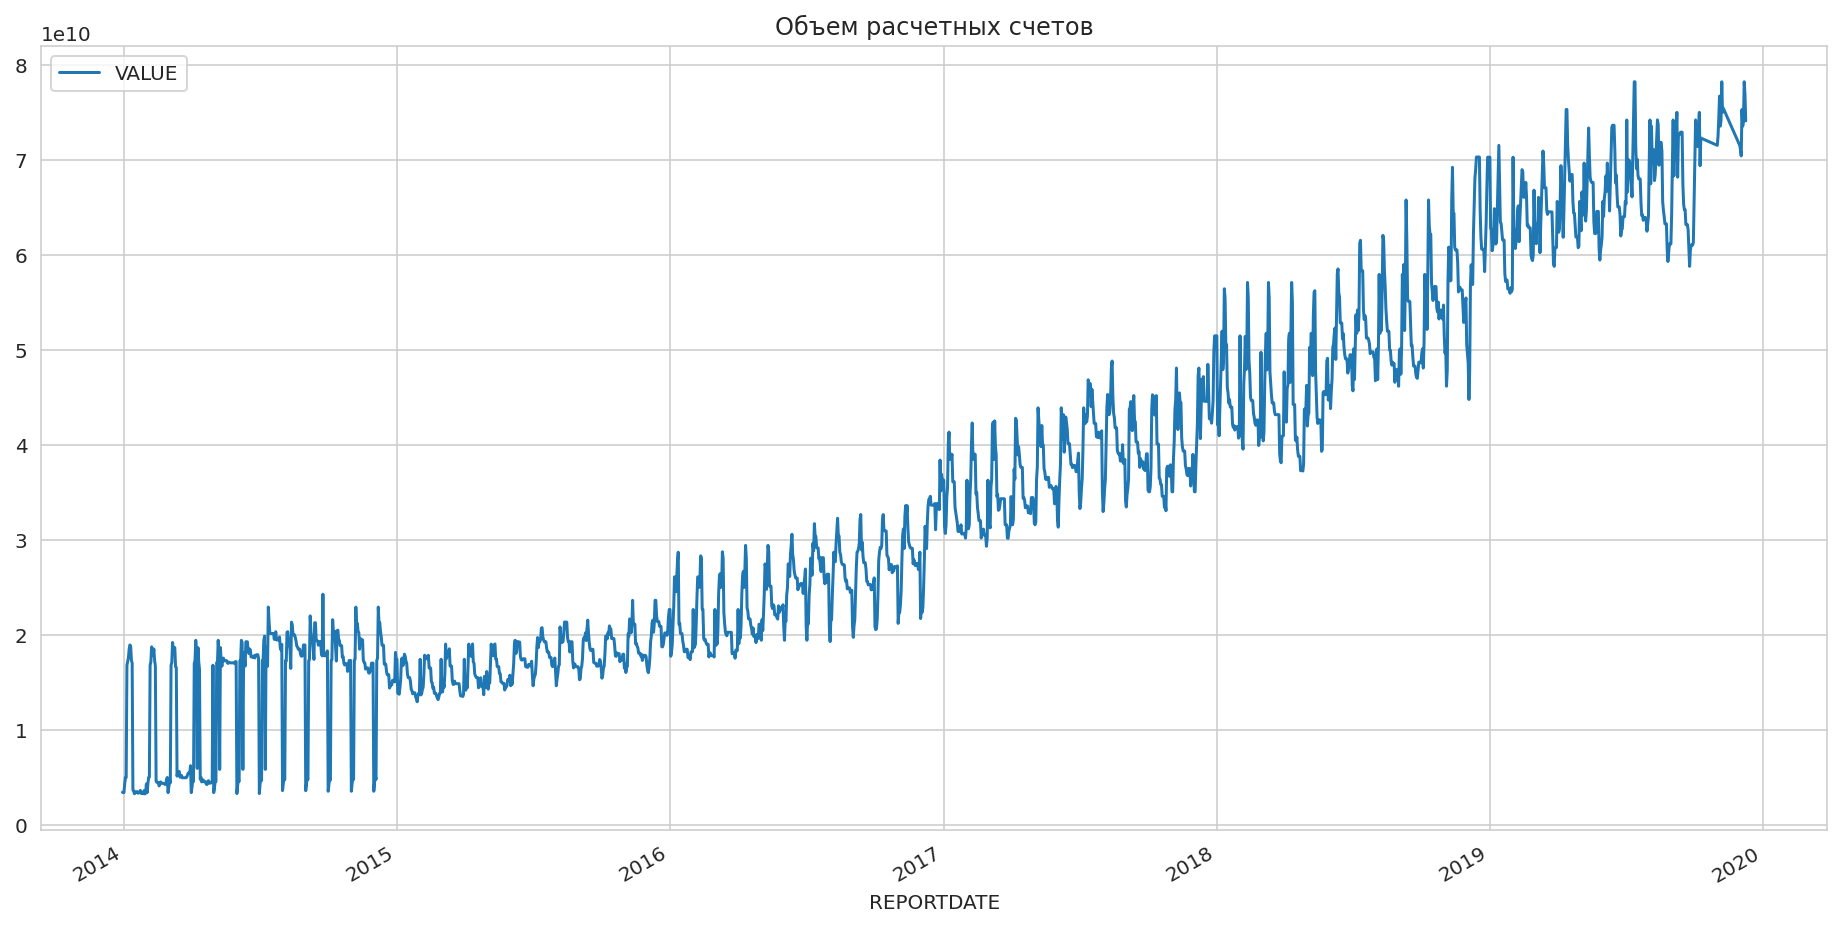

In [ ]:
%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')
data.plot(title='Объем расчетных счетов', figsize=(16, 8))

Посмотрим на количество дней в каждом году:

In [ ]:
data.groupby(data.index.year).count()['VALUE']

REPORTDATE
2013      2
2014    365
2015    365
2016    366
2017    365
2018    365
2019    283
Name: VALUE, dtype: int64

Обнаружили, что 2013 год имеет только два дня, а в 2019 годе отсутствует  82 дня

Удалим 2013 год полностью

In [ ]:
data = data.loc[data.index.year > 2013]

Ресемплинг в 1 месяц

In [ ]:
one_month = data.resample('1M').sum()

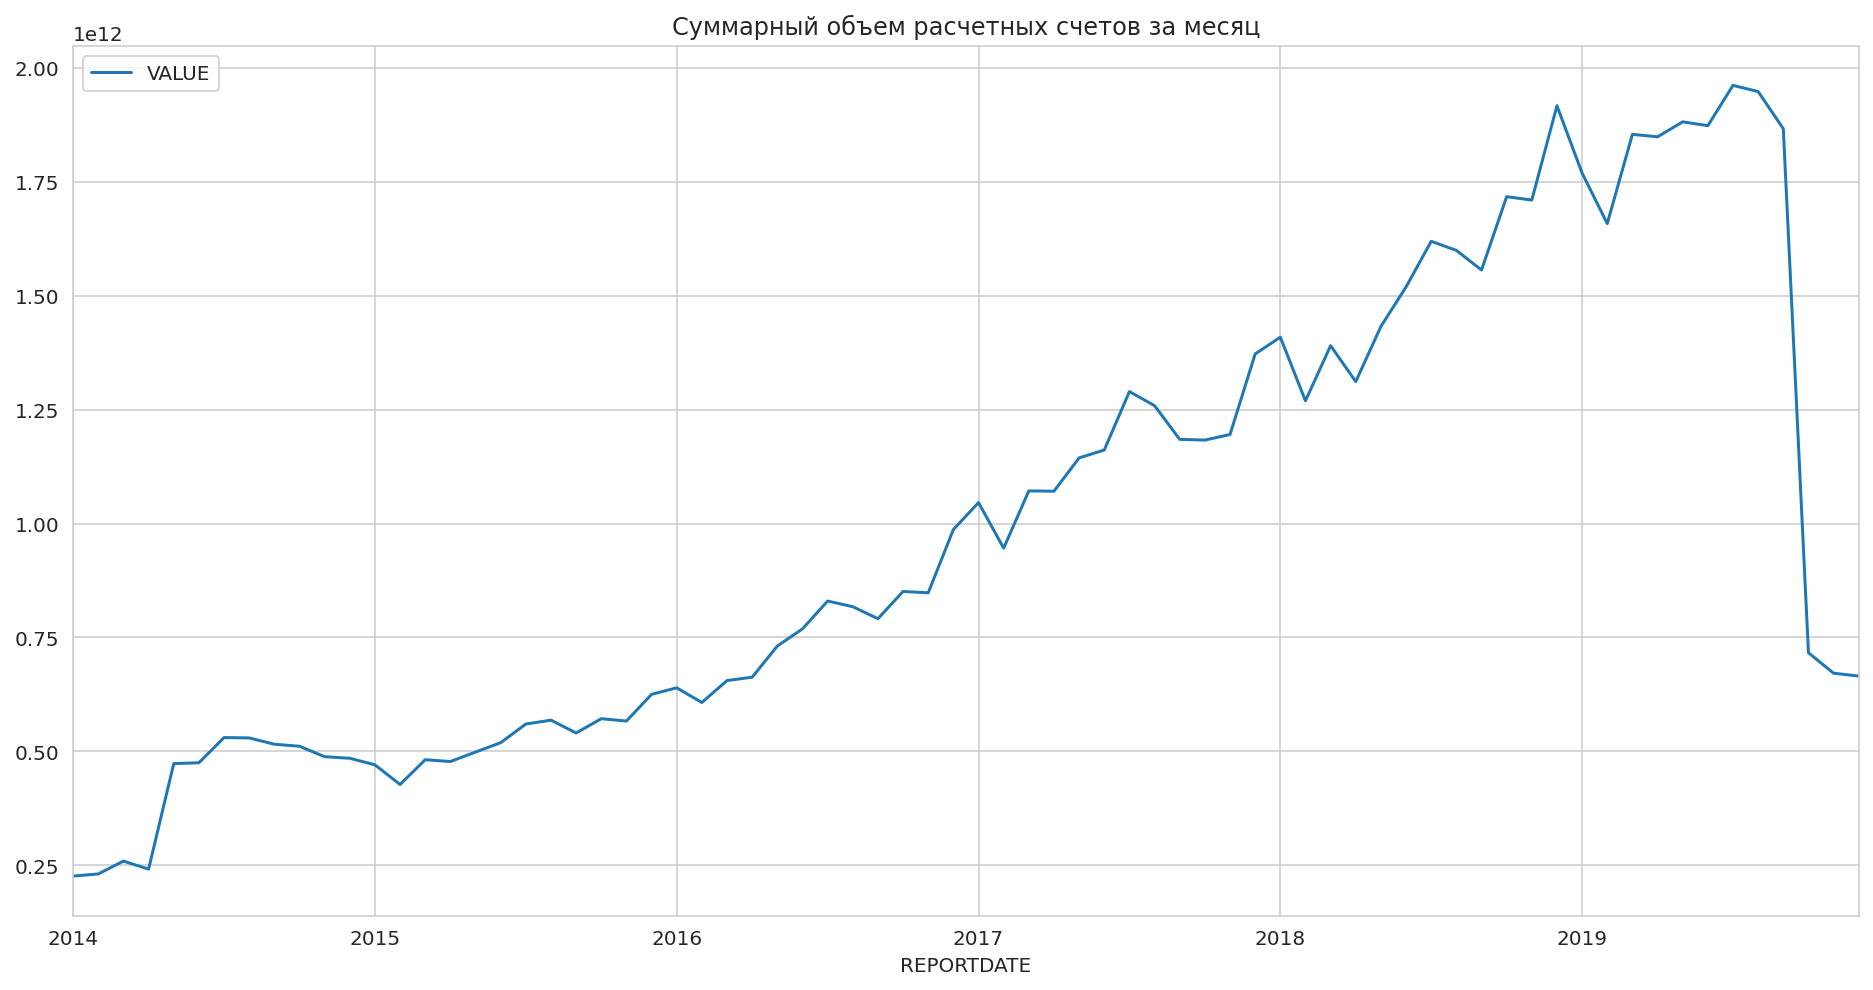

In [ ]:
%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')
one_month.plot(title='Суммарный объем расчетных счетов за месяц', figsize=(16, 8))

Посчитаем сколько дней в каждом месяце в 2019 году было пропущено:

In [ ]:
pd.date_range(
  start="2019-01-01", end="2019-12-31").difference(data.index).month.value_counts()

12    22
10    21
11    21
1      2
2      2
3      2
4      2
5      2
6      2
7      2
8      2
9      2
dtype: int64

Откажемся от последних трех месяцев, т.к. в них больше всего пропусков:

In [ ]:
data = data.loc[(data.index.year != 2019) | (~data.index.month.isin([10, 11, 12]))]
one_month = data.resample('1M').sum()

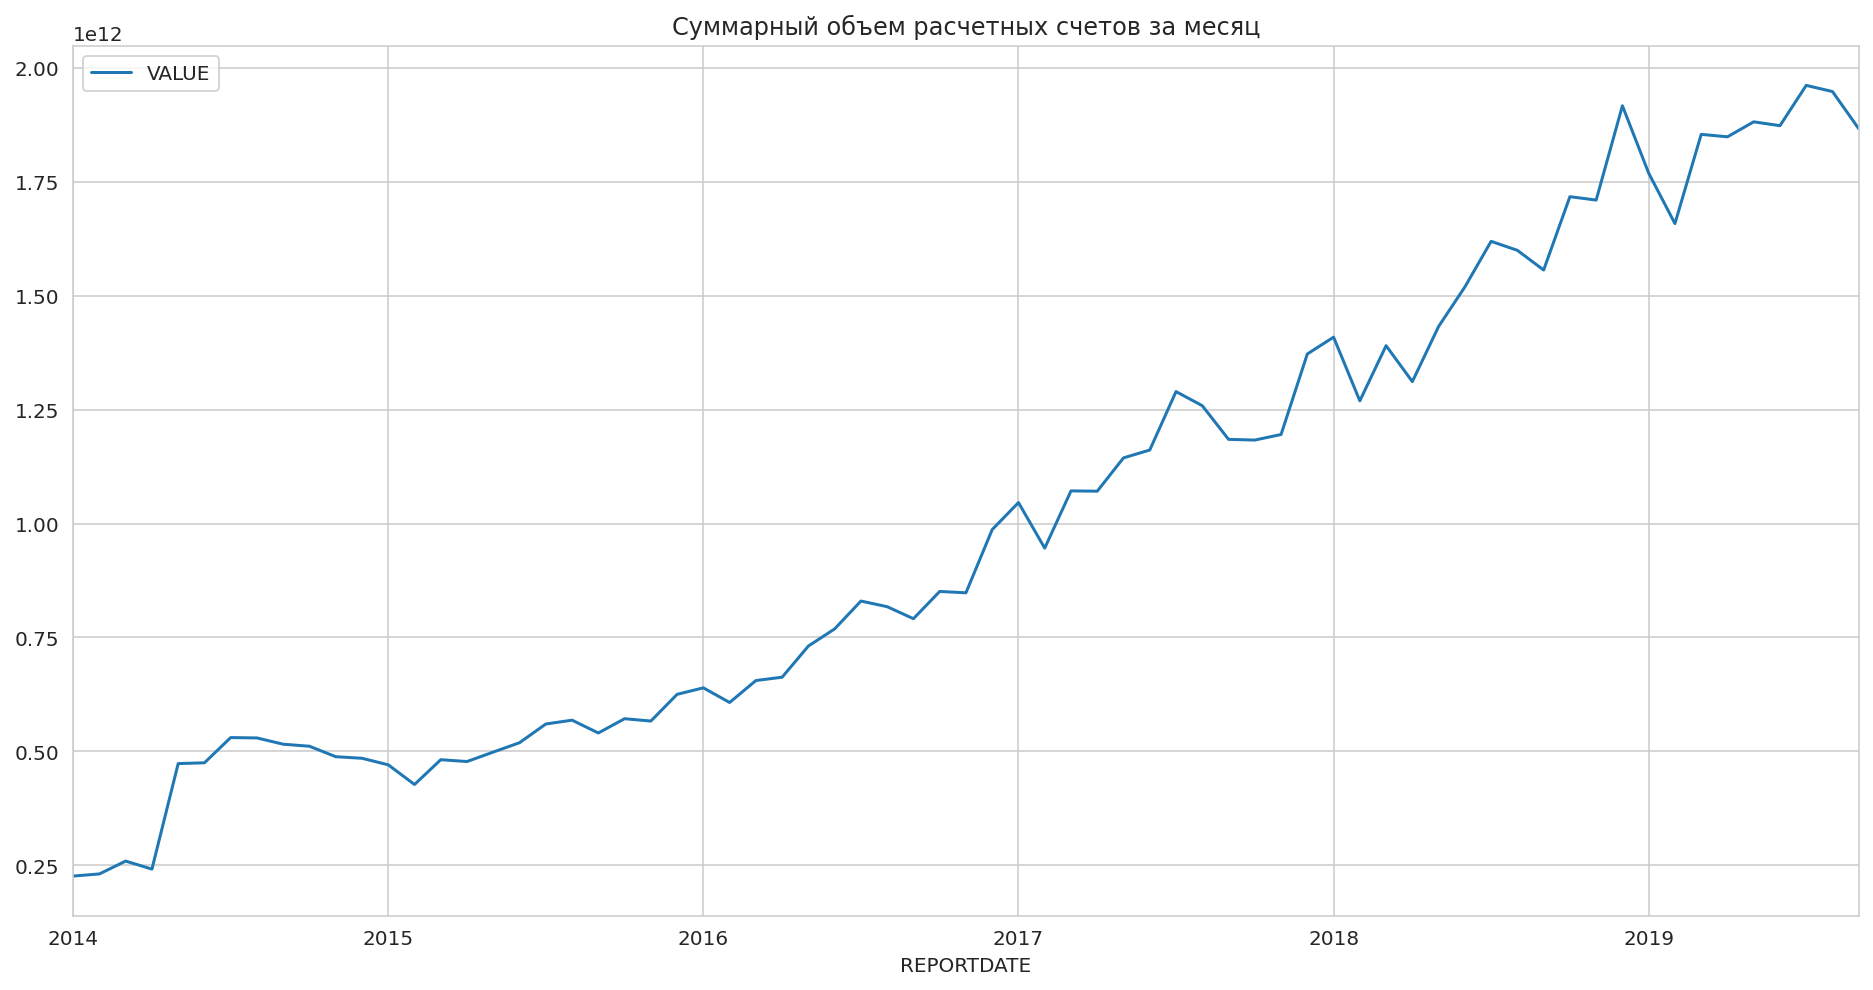

In [ ]:
%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')
one_month.plot(title='Суммарный объем расчетных счетов за месяц', figsize=(16, 8))

Скользящая средняя на квартал и полгода:

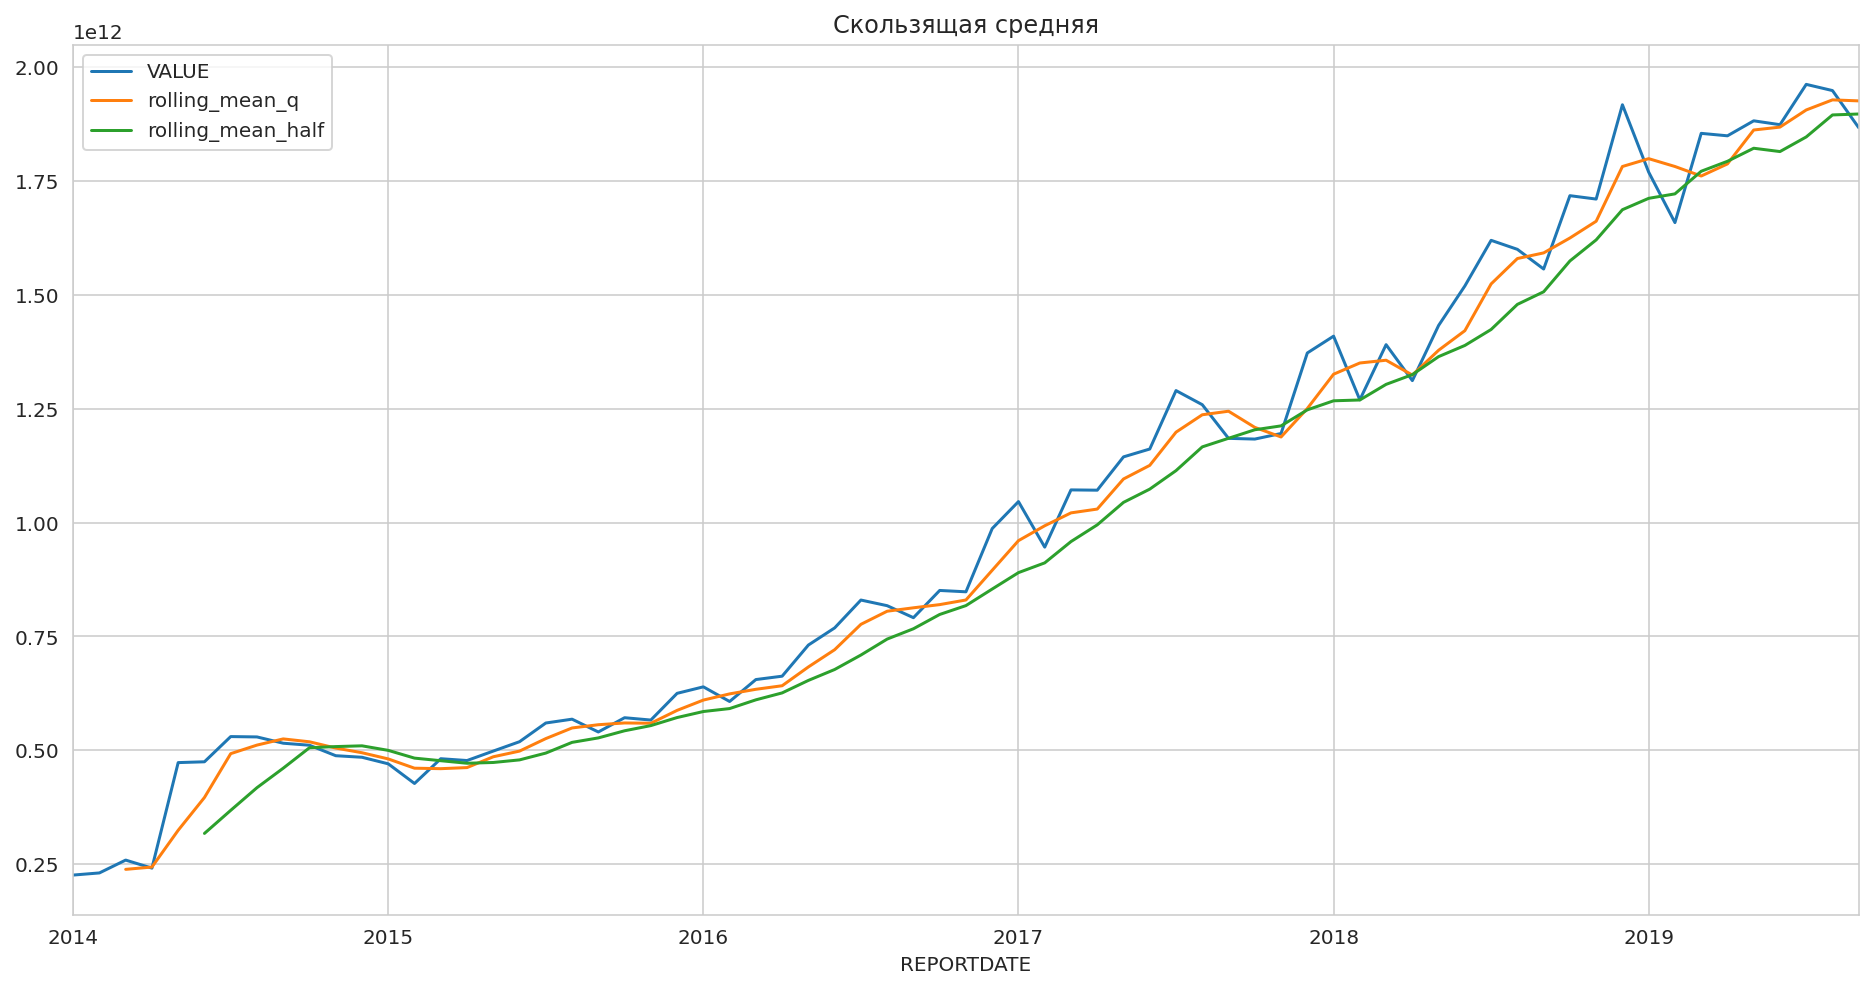

In [ ]:
one_month['rolling_mean_q'] = one_month['VALUE'].rolling(3).mean()
one_month['rolling_mean_half'] = one_month['VALUE'].rolling(6).mean()

one_month.plot(title='Скользящая средняя', figsize=(16, 8))

In [ ]:
decomposed = seasonal_decompose(one_month['VALUE'])

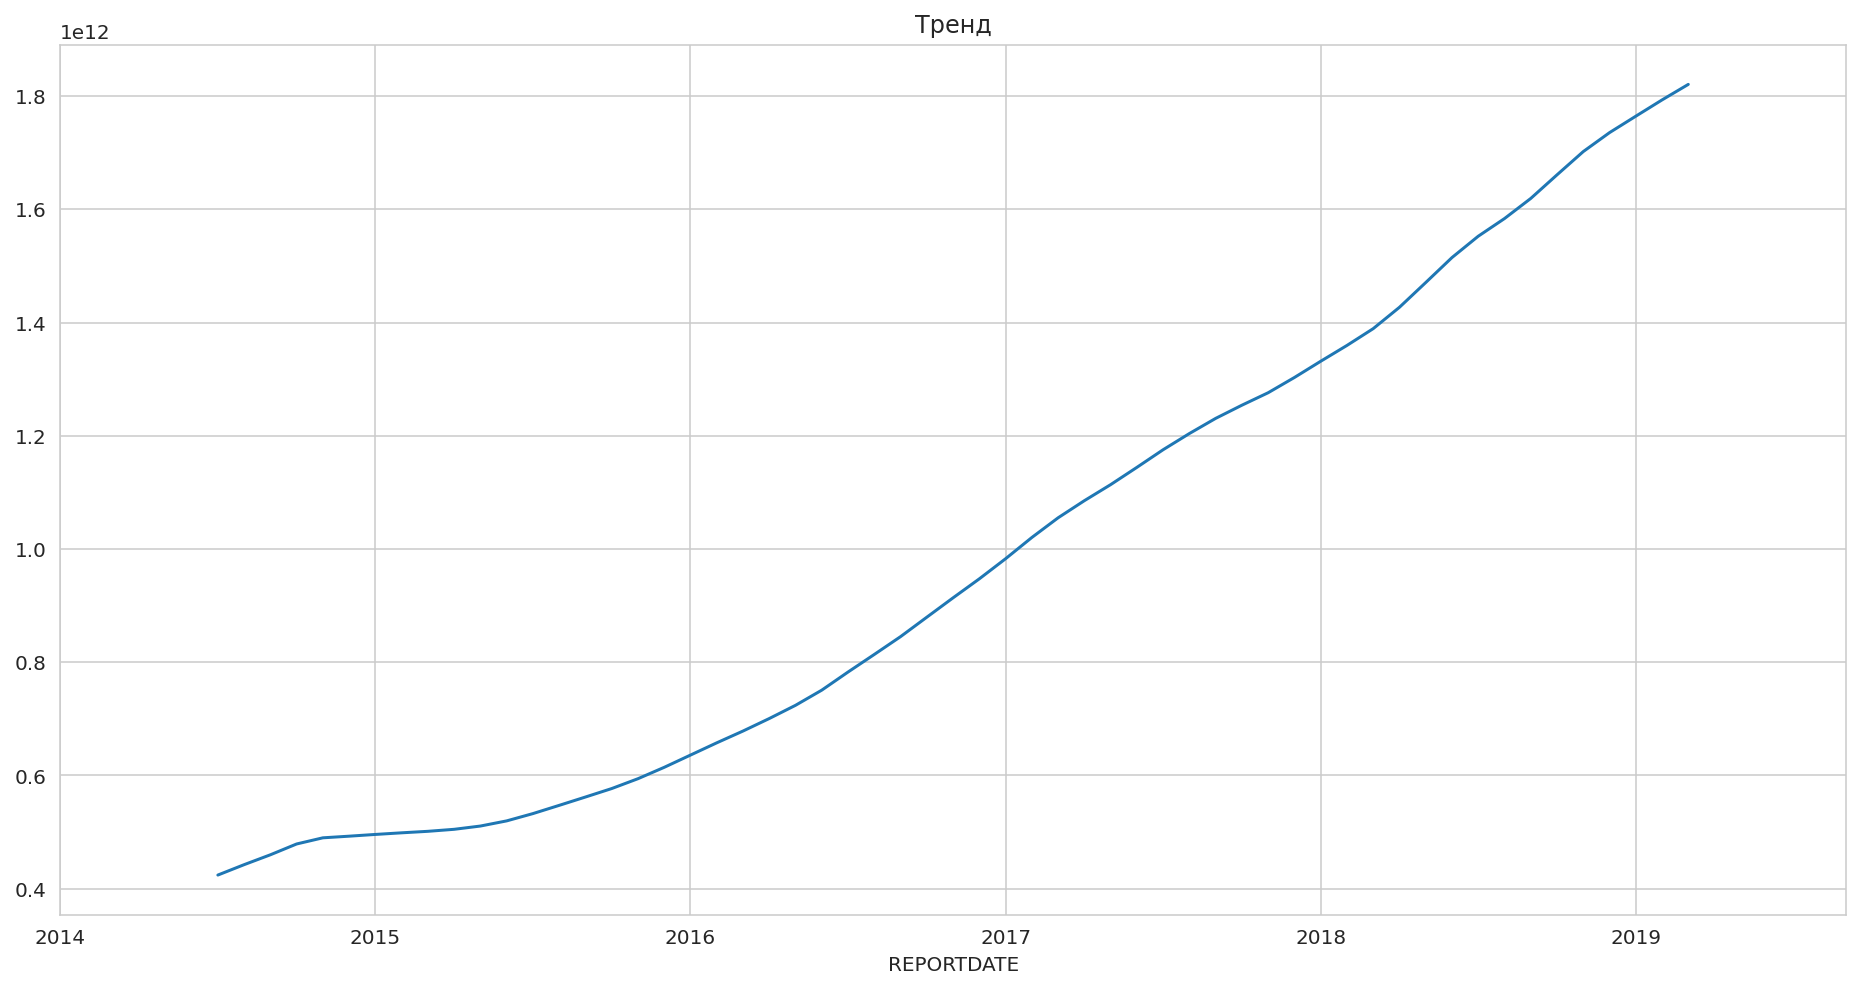

In [ ]:
decomposed.trend.plot(title='Тренд', figsize=(16, 8))

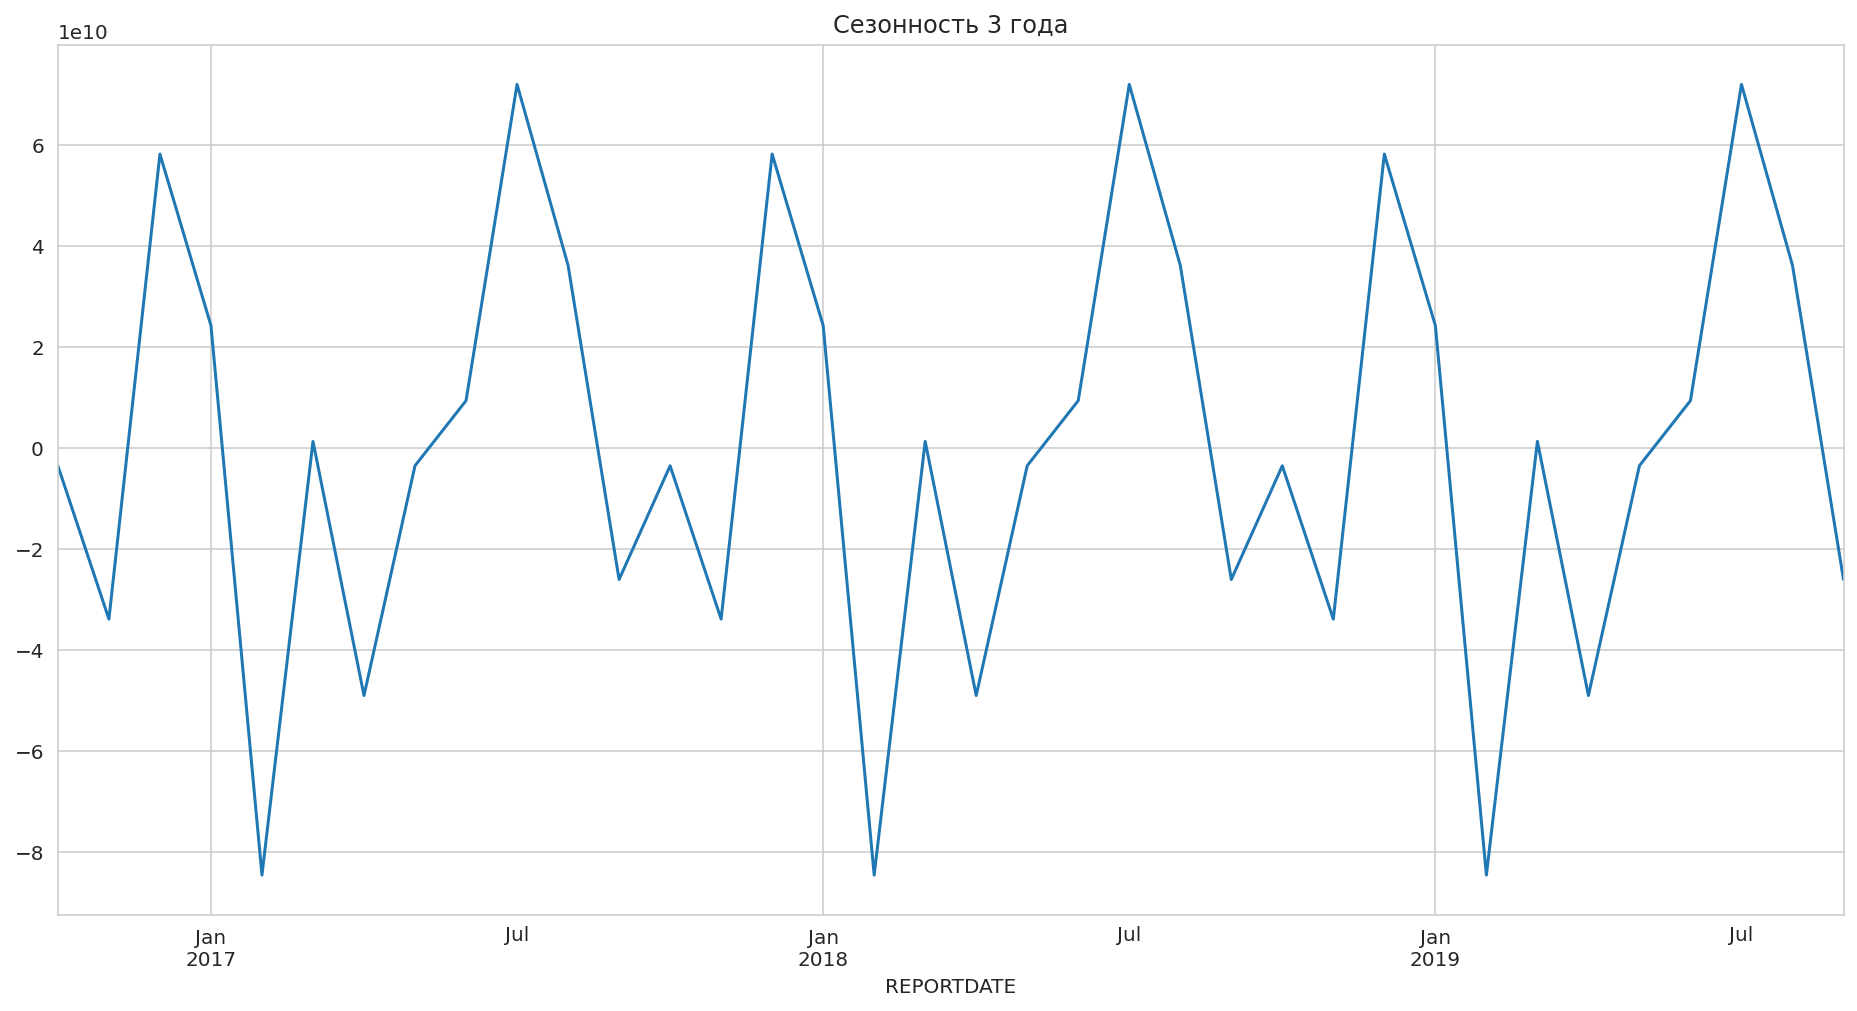

In [ ]:
decomposed.seasonal.tail(12 * 3).plot(title='Сезонность 3 года', figsize=(16, 8));

Отдельно за год:

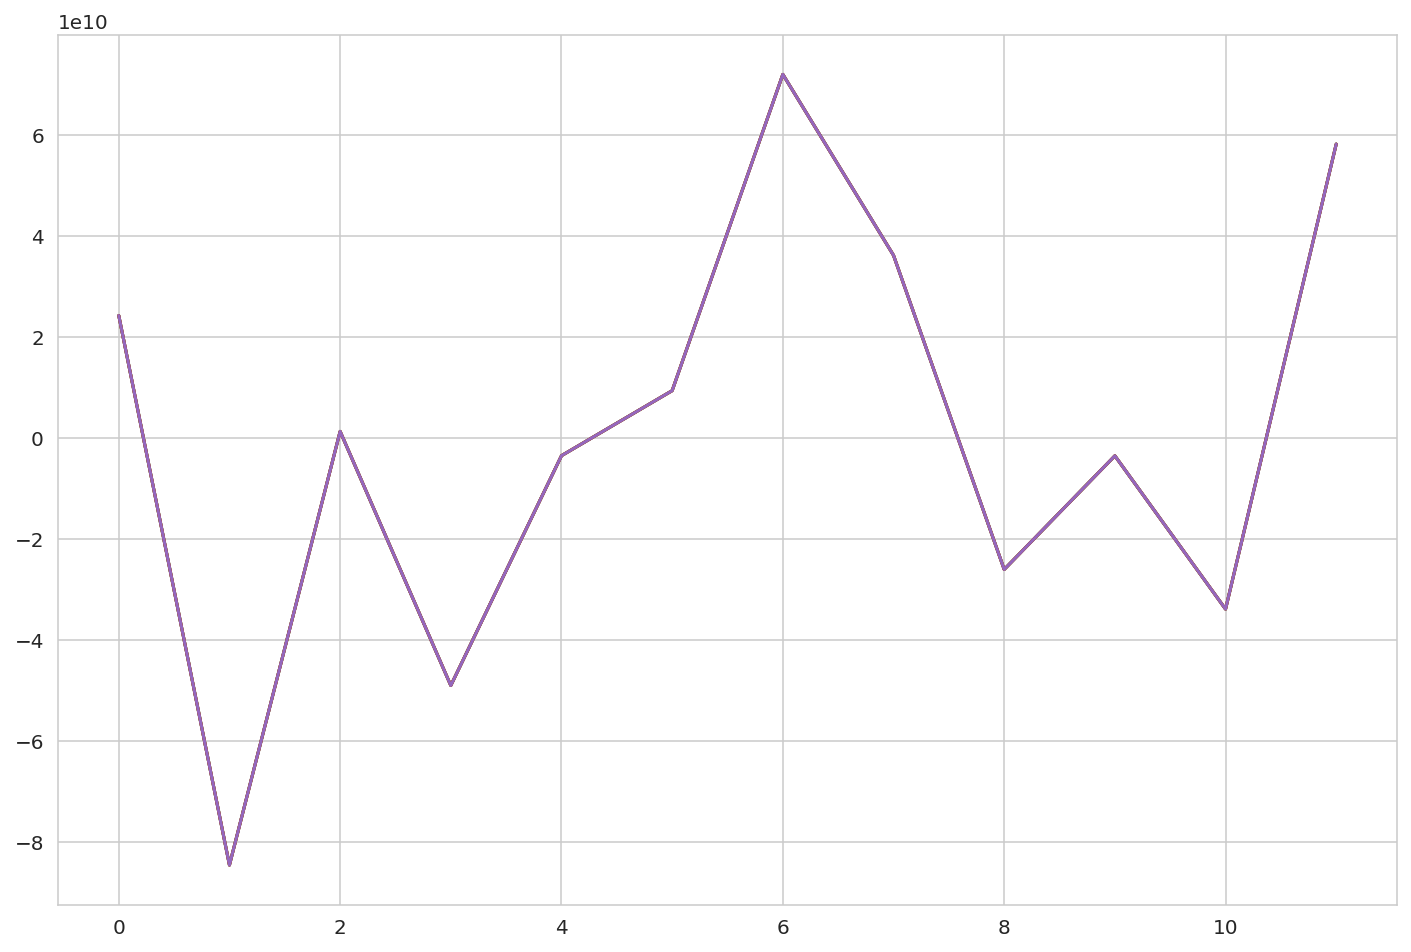

In [ ]:
fig = plt.figure(figsize=(12, 8))
counter = 12
while counter < decomposed.seasonal.shape[0]:
    plt.plot(decomposed.seasonal[counter-12:counter].reset_index(drop=True), figure=fig)
    counter += 12

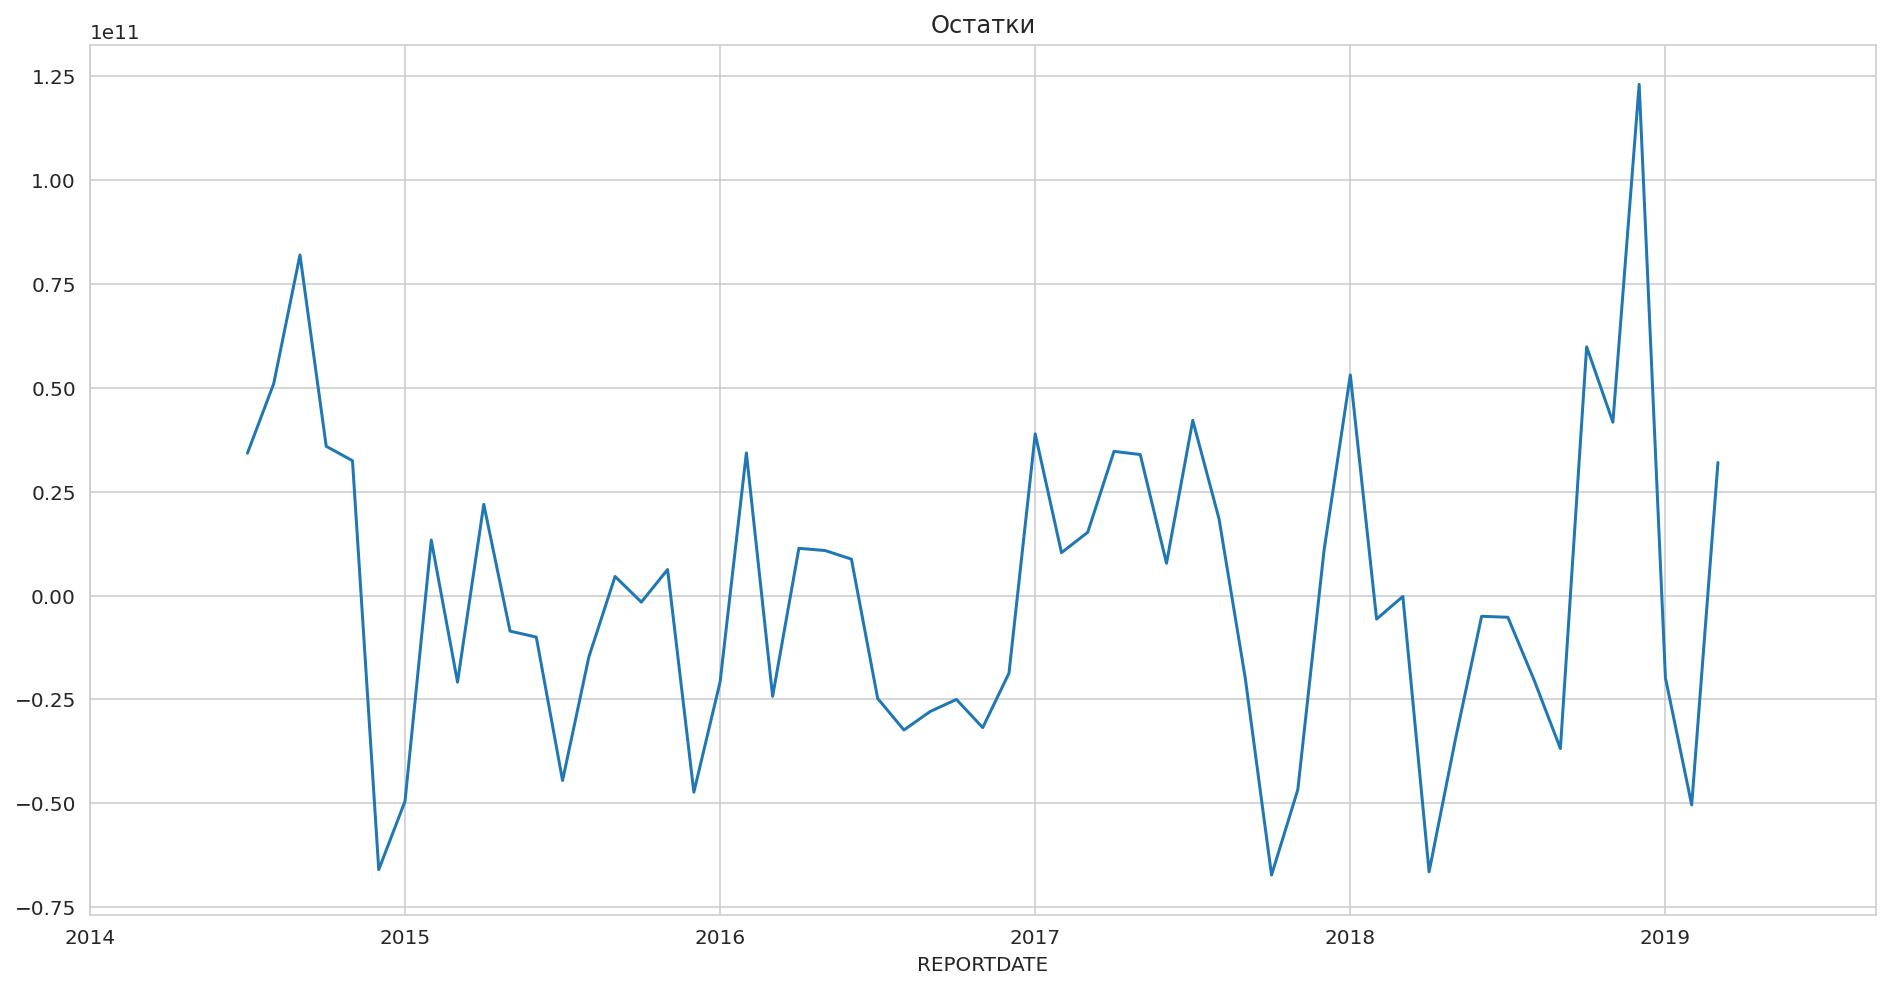

In [ ]:
decomposed.resid.plot(title='Остатки', figsize=(16, 8));

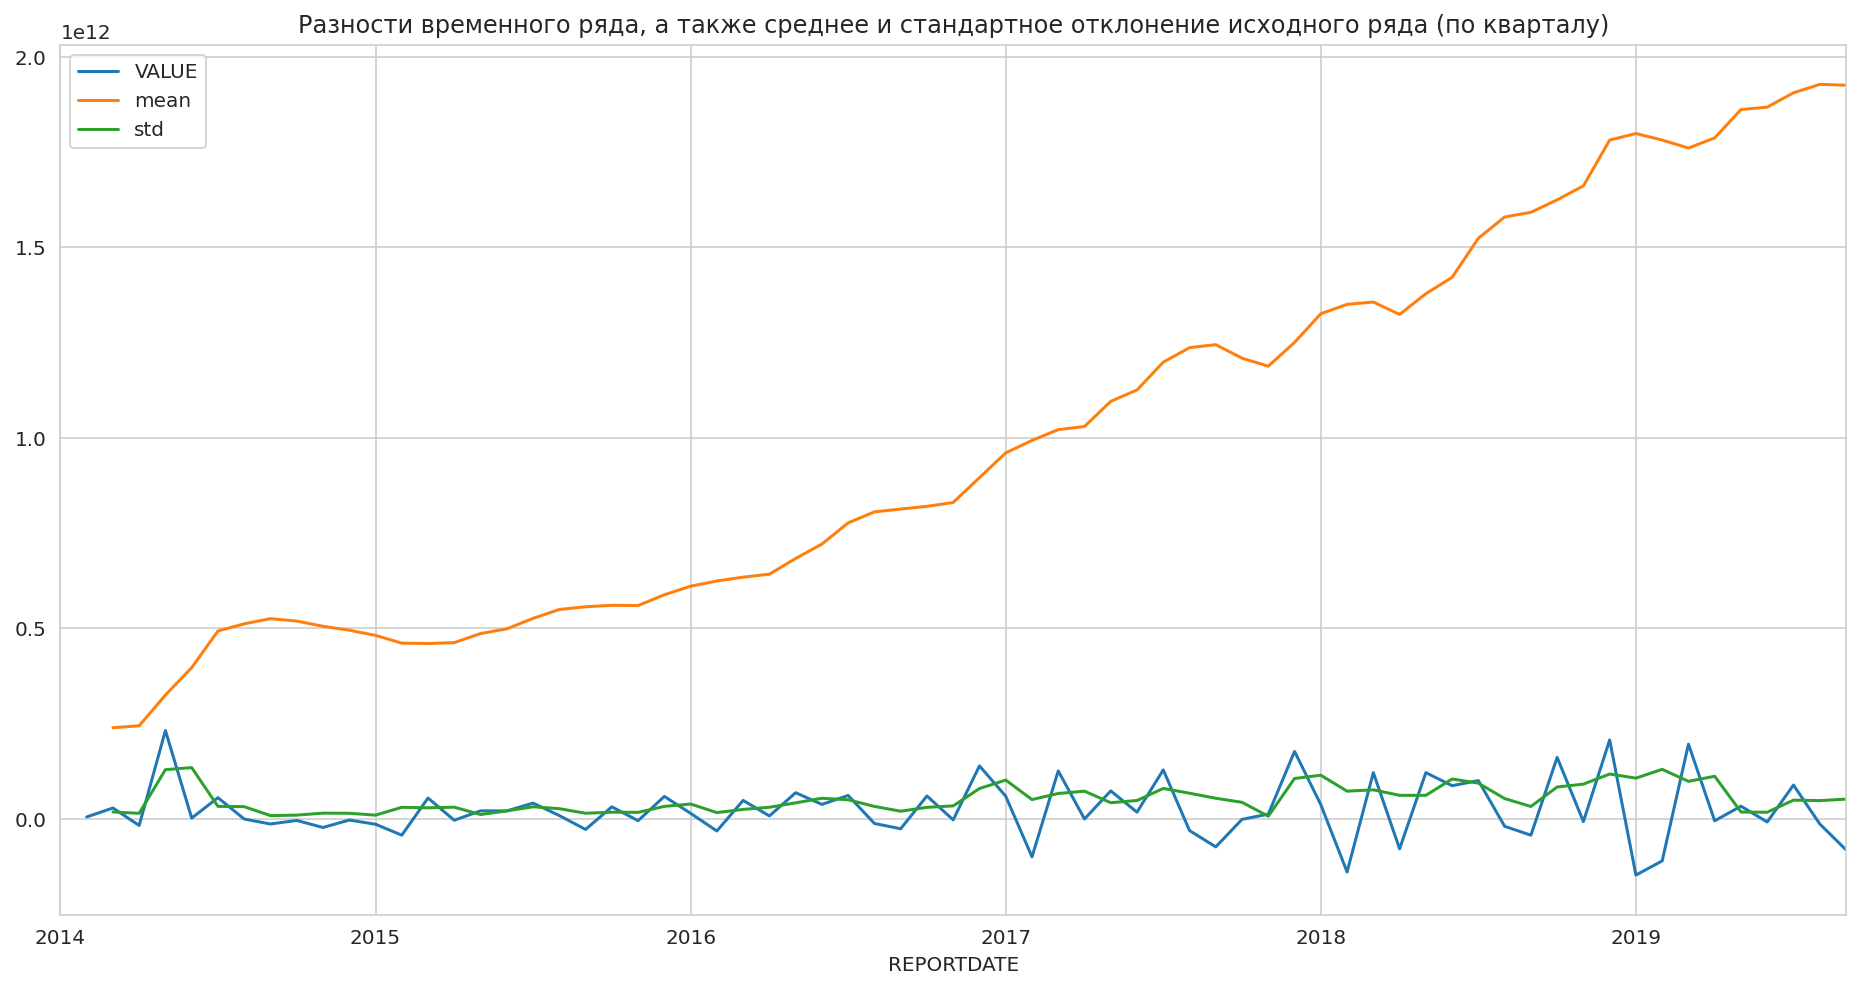

In [ ]:
data_month_shift = pd.DataFrame()
data_month_shift['VALUE'] = one_month['VALUE'] - one_month['VALUE'].shift()
data_month_shift['mean'] = one_month['VALUE'].rolling(3).mean()
data_month_shift['std'] = one_month['VALUE'].rolling(3).std()
data_month_shift.plot(title='Разности временного ряда, а также среднее и стандартное отклонение исходного ряда (по кварталу)', figsize=(16, 8));

Проверим явно стационарность ряда через Тест Дики — Фуллера:

In [ ]:
ts = data['VALUE']
st_test = adfuller(ts, regression='ctt')

if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Наш ряд стационарный


**Промежуточный итог:**
* Избавились от аномалии в лице 2013-го года
* Удалили последние три месяца 2019 года, т.к. количество пропущенных дней было больше половины в каждом месяце
* Сделали ресемплинг в 1 месяц с суммой
* Рассмотрели тренд, сезонность, остатки
  * Прослеживается явный тренд
  * В районе января ощутимое падение объемов, максимум же находится в районе июня
* Провели Тест Дики - Фуллера, чтобы явно проверить стационарность ряда

### Признаки для обучения

In [ ]:
def features(df, max_lag=6, rolling_mean_size=3):
    data = df.copy()
    data = data.resample('1M').sum()
    # Возьмем в миллионах
    data['VALUE'] = data['VALUE'] / 1000000
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['quarter'] = (data.index.month // 4 + 1)
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['VALUE'].shift(lag)

    data['rolling_mean_shift'] = data['VALUE'].shift().rolling(rolling_mean_size).mean()
    return data

In [ ]:
train, test = train_test_split(features(data), shuffle=False, test_size=12, random_state=RANDOM_STATE)
train = train.dropna()
    
features_train = train.drop('VALUE', axis=1)
target_train = train['VALUE']

features_test = test.drop('VALUE', axis=1)
target_test = test['VALUE']

In [ ]:
features_train.head()

,month,year,quarter,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean_shift
REPORTDATE,,,,,,,,,,
2014-07-31,7,2014,2,474965.664469,473199.349711,241668.786249,259282.870189,231094.588471,226414.618857,396611.266810
2014-08-31,8,2014,3,530288.889753,474965.664469,473199.349711,241668.786249,259282.870189,231094.588471,492817.967978
2014-09-30,9,2014,3,529531.197445,530288.889753,474965.664469,473199.349711,241668.786249,259282.870189,511595.250556
2014-10-31,10,2014,3,515731.811358,529531.197445,530288.889753,474965.664469,473199.349711,241668.786249,525183.966185
2014-11-30,11,2014,3,511288.434426,515731.811358,529531.197445,530288.889753,474965.664469,473199.349711,518850.481076


In [ ]:
features_train.shape

(51, 10)

In [ ]:
features_test.shape

(12, 10)

### Обучение моделей

Функции для расчета `MSE` и `суммы пробития`

In [ ]:
def RMSE(y_test, y_pred):
    return mean_squared_error(y_test, y_pred, squared=False)

def breakline(y, y_pred):
    """
    Если y[i] оказался ниже предсказанной границы, то суммируем их разницу
    """
    s = 0
    for i in range(len(y)):
        s += max(0, y_pred[i] - y[i])
    return s

In [ ]:
# Результаты моделей:

result = {}

#### LogReg

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(features_train, target_train)

pred_test = lin_reg.predict(features_test)

lin_reg_rmse = RMSE(target_test, pred_test)
lin_reg_breakline = breakline(target_train.append(target_test), lin_reg.predict(features_train.append(features_test)))
print(f'RMSE линейной регрессии на тестовой выборке: {lin_reg_rmse:3}')
print(f'Сумма пробития линейной регрессии на тестовой выборке: {lin_reg_breakline:3}')

RMSE линейной регрессии на тестовой выборке: 94275.47944286907
Сумма пробития линейной регрессии на тестовой выборке: 1487418.7753682856


In [ ]:
result['LogReg'] = [lin_reg_rmse, lin_reg_breakline]

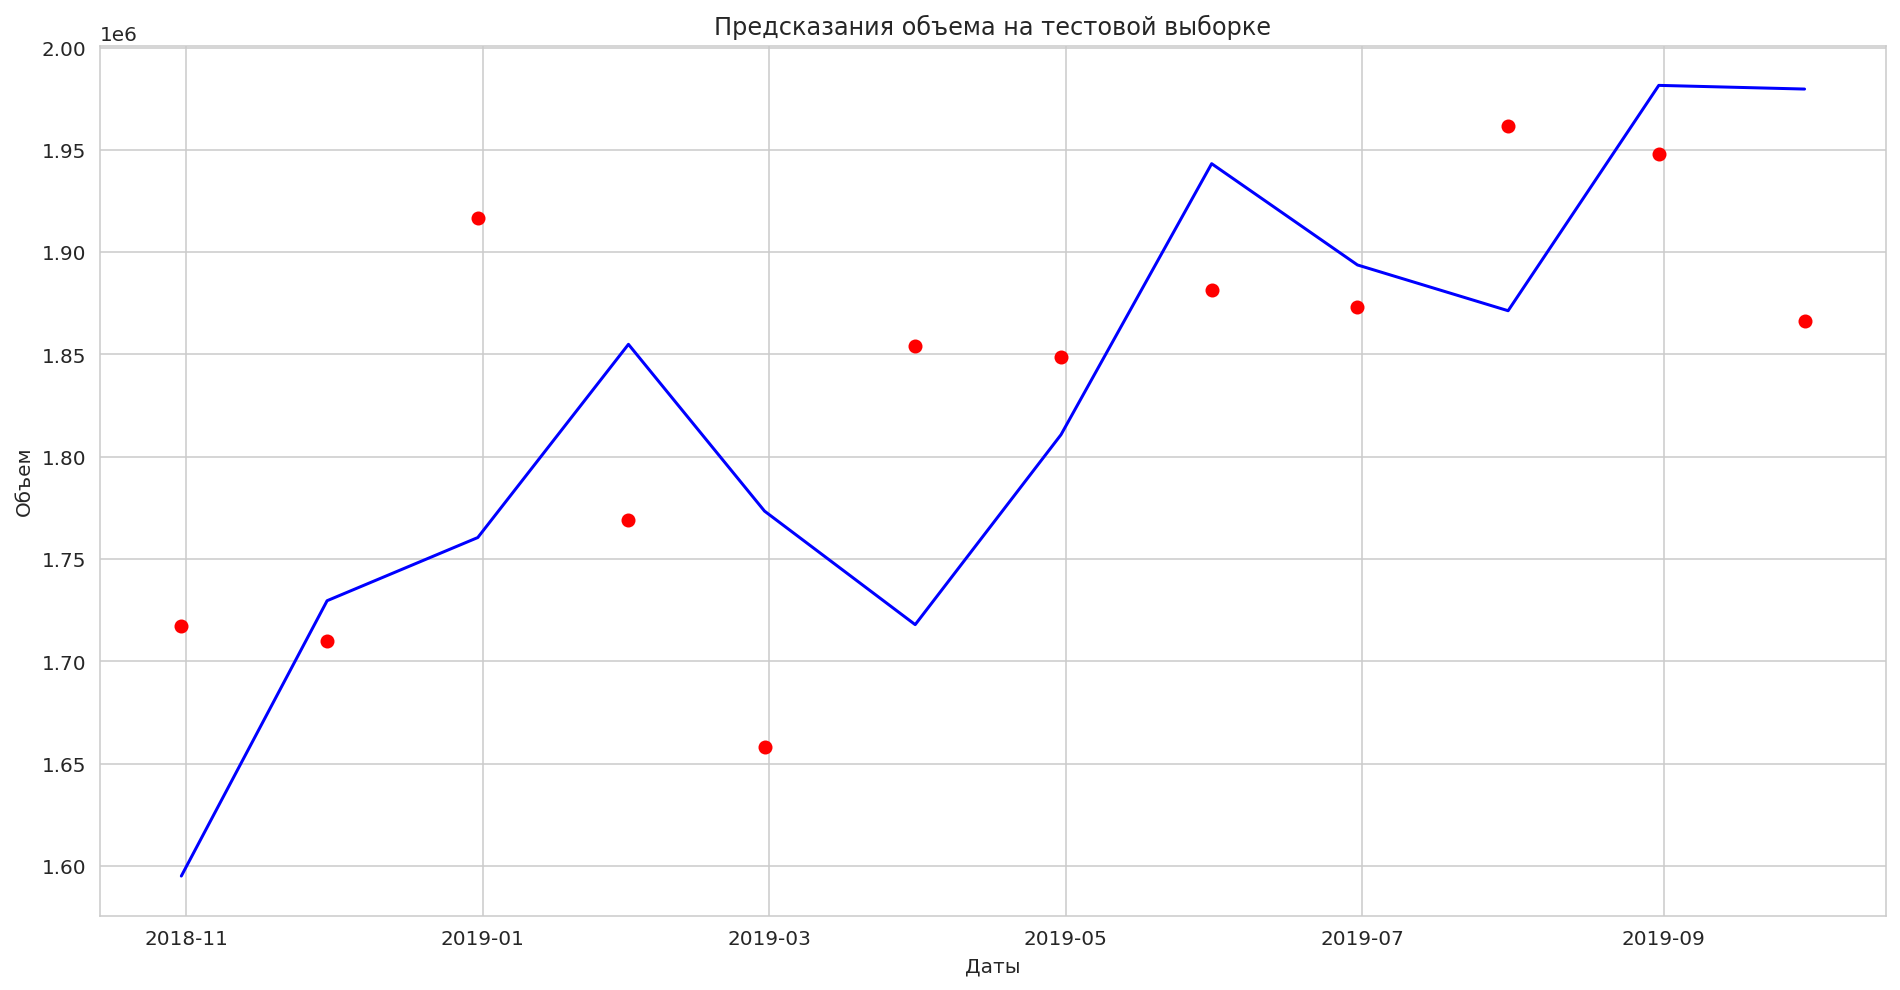

In [ ]:
plt.figure(figsize=(16, 8))
plt.scatter(features_test.index, target_test, color = 'red')
plt.plot(features_test.index, pred_test, color = 'blue')
plt.title('Предсказания объема на тестовой выборке')
plt.xlabel('Даты')
plt.ylabel('Объем')
plt.show()

#### QuantileRegressor

Пробуем QuantileRegressor

Подберем гиперпараметры:

In [ ]:
param_grid = {
    'alpha': np.arange(0.1, 5, 0.5),
    'solver': ['highs-ds', 'highs', 'interior-point', 'revised simplex'],
}

model = QuantileRegressor()

# Не забываем про правильную кросс-валидацию
tscv = TimeSeriesSplit(n_splits=5)

clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')

In [ ]:
%%time
clf.fit(features_train, target_train)

CPU times: user 543 ms, sys: 103 ms, total: 646 ms
Wall time: 3.78 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_quantile.py:277: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
Status is 4: Numerical difficulties encountered.
Result message of linprog:
The solution does not satisfy the constraints within the required tolerance of 3.16E-04, yet no errors were raised and there is no certificate of infeasibility or unboundedness. Check whether the slack and constraint residuals are acceptable; if not, consider enabling presolve, adjusting the tolerance option(s), and/or using a different method. Please consider submitting a bug report.
  ConvergenceWarning,


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=QuantileRegressor(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]),
                         'solver': ['highs-ds', 'highs', 'interior-point',
                                    'revised simplex']},
             scoring='neg_root_mean_squared_error')

In [ ]:
qr = clf.best_estimator_

In [ ]:
features_train_tail_test = features_train.tail(15).append(features_test)

In [ ]:
y_pred = qr.predict(features_train_tail_test)
y_pred_all = qr.predict(features_train.append(features_test))


In [ ]:
h_alpha = 0.90
l_alpha = 1 - h_alpha

qr.set_params(quantile=h_alpha)
qr.fit(features_train, target_train)
y_upper = qr.predict(features_train_tail_test)
y_upper_all = qr.predict(features_train.append(features_test))

qr.set_params(quantile=l_alpha)
qr.fit(features_train, target_train)
y_lower = qr.predict(features_train_tail_test)
y_lower_all = qr.predict(features_train.append(features_test))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_quantile.py:277: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
Status is 4: Numerical difficulties encountered.
Result message of linprog:
The solution does not satisfy the constraints within the required tolerance of 3.16E-04, yet no errors were raised and there is no certificate of infeasibility or unboundedness. Check whether the slack and constraint residuals are acceptable; if not, consider enabling presolve, adjusting the tolerance option(s), and/or using a different method. Please consider submitting a bug report.
  ConvergenceWarning,


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  if __name__ == '__main__':


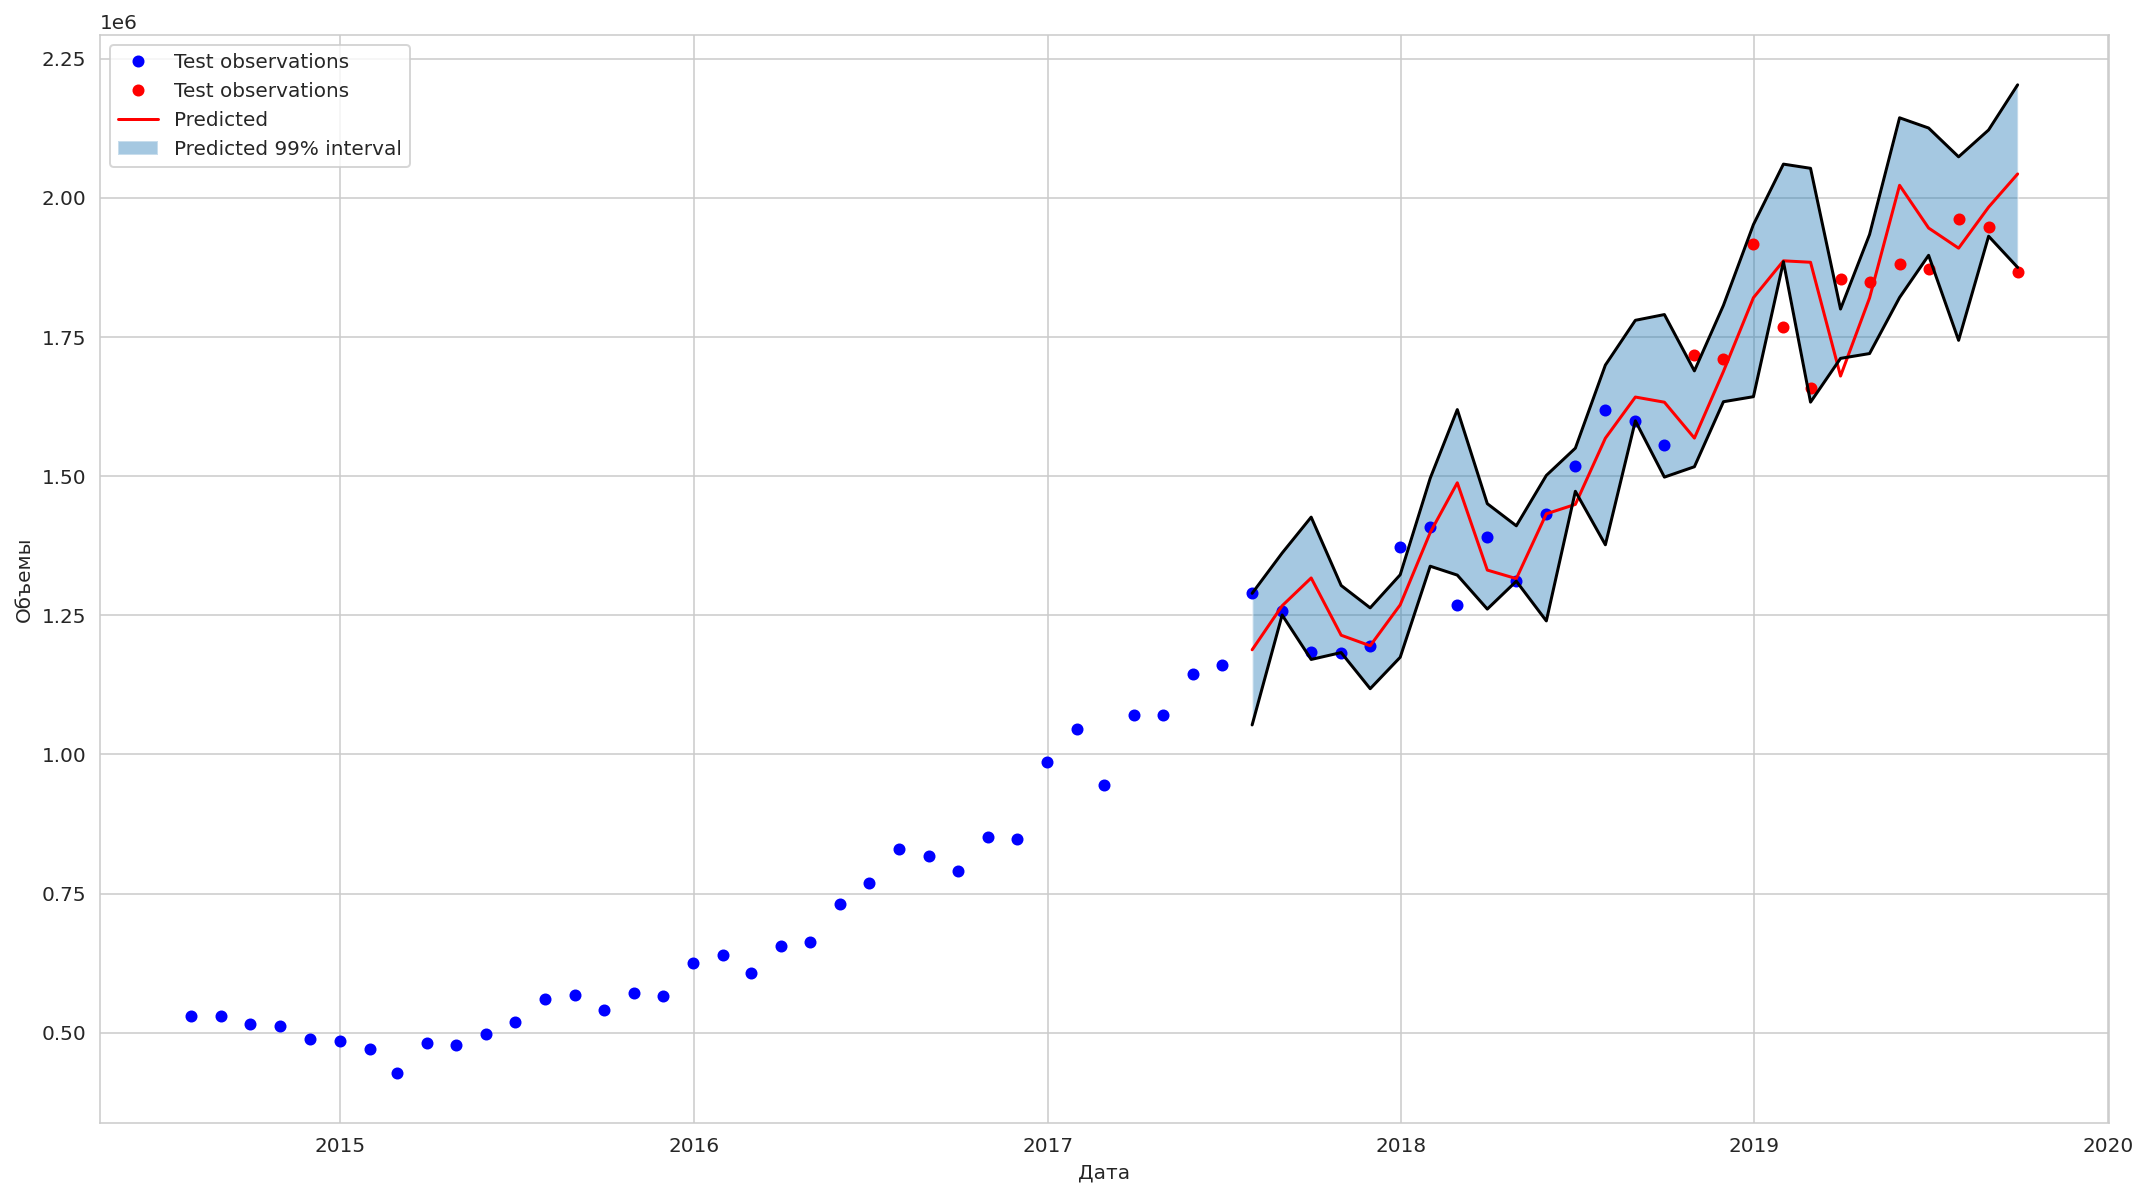

In [ ]:
fig = plt.figure(figsize=(18, 10))
plt.plot(features_train.index, target_train.values, "b.", markersize=10, label="Test observations")
plt.plot(features_test.index, target_test.values, "r.", markersize=10, label="Test observations")

plt.plot(features_train_tail_test.index, y_pred, "r-", label="Predicted")
plt.plot(features_train_tail_test.index, y_upper, "k-")
plt.plot(features_train_tail_test.index, y_lower, "k-")
plt.fill_between(
    features_train_tail_test.index.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 99% interval"
)
plt.xlabel("Дата")
plt.ylabel("Объемы")
plt.legend(loc="upper left")
plt.show()

In [ ]:
real_mse = RMSE(target_test, y_pred[-12:])
real_break = breakline(target_train.append(target_test), y_pred_all)
lower_mse = RMSE(target_test, y_lower[-12:])
lower_break = breakline(target_train.append(target_test), y_lower_all)
upper_mse = RMSE(target_test, y_upper[-12:])
upper_break = breakline(target_train.append(target_test), y_upper_all)

print("QuantileRegressor real RMSE:", real_mse)
print("Пробитие:", real_break)
print(f"QuantileRegressor alpha {round(l_alpha, 4)} RMSE:", lower_mse)
print("Пробитие:", lower_break)
print(f"QuantileRegressor alpha {round(h_alpha, 4)} RMSE:", upper_mse)
print("Пробитие:", upper_break)

QuantileRegressor real RMSE: 125322.88256722991
Пробитие: 1873067.3439474008
QuantileRegressor alpha 0.1 RMSE: 136458.96272621743
Пробитие: 221280.69096860802
QuantileRegressor alpha 0.9 RMSE: 214526.43710769305
Пробитие: 5150722.865928268


In [ ]:
result['QuantReg_real'] = [real_mse, real_break]
result['QuantReg_lower'] = [lower_mse, lower_break]
result['QuantReg_upper'] = [upper_mse, upper_break]


#### Orbit

In [ ]:
pip install orbit-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 474 kB 5.0 MB/s 
     |████████████████████████████████| 718 kB 52.0 MB/s 
     |████████████████████████████████| 11.2 MB 44.5 MB/s 
     |████████████████████████████████| 67.3 MB 141 kB/s 
     |████████████████████████████████| 957 kB 44.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0


In [ ]:
%matplotlib inline
import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data

In [ ]:
dlt = DLT(response_col='VALUE',
          date_col='REPORTDATE',
          seed=8888)

In [ ]:
train, test = pd.concat([target_train, features_train], axis=1).reset_index(), pd.concat([target_test, features_test], axis=1).reset_index()

In [ ]:
%%time
dlt.fit(df=train)

CPU times: user 2.21 s, sys: 292 ms, total: 2.5 s
Wall time: 1min 44s


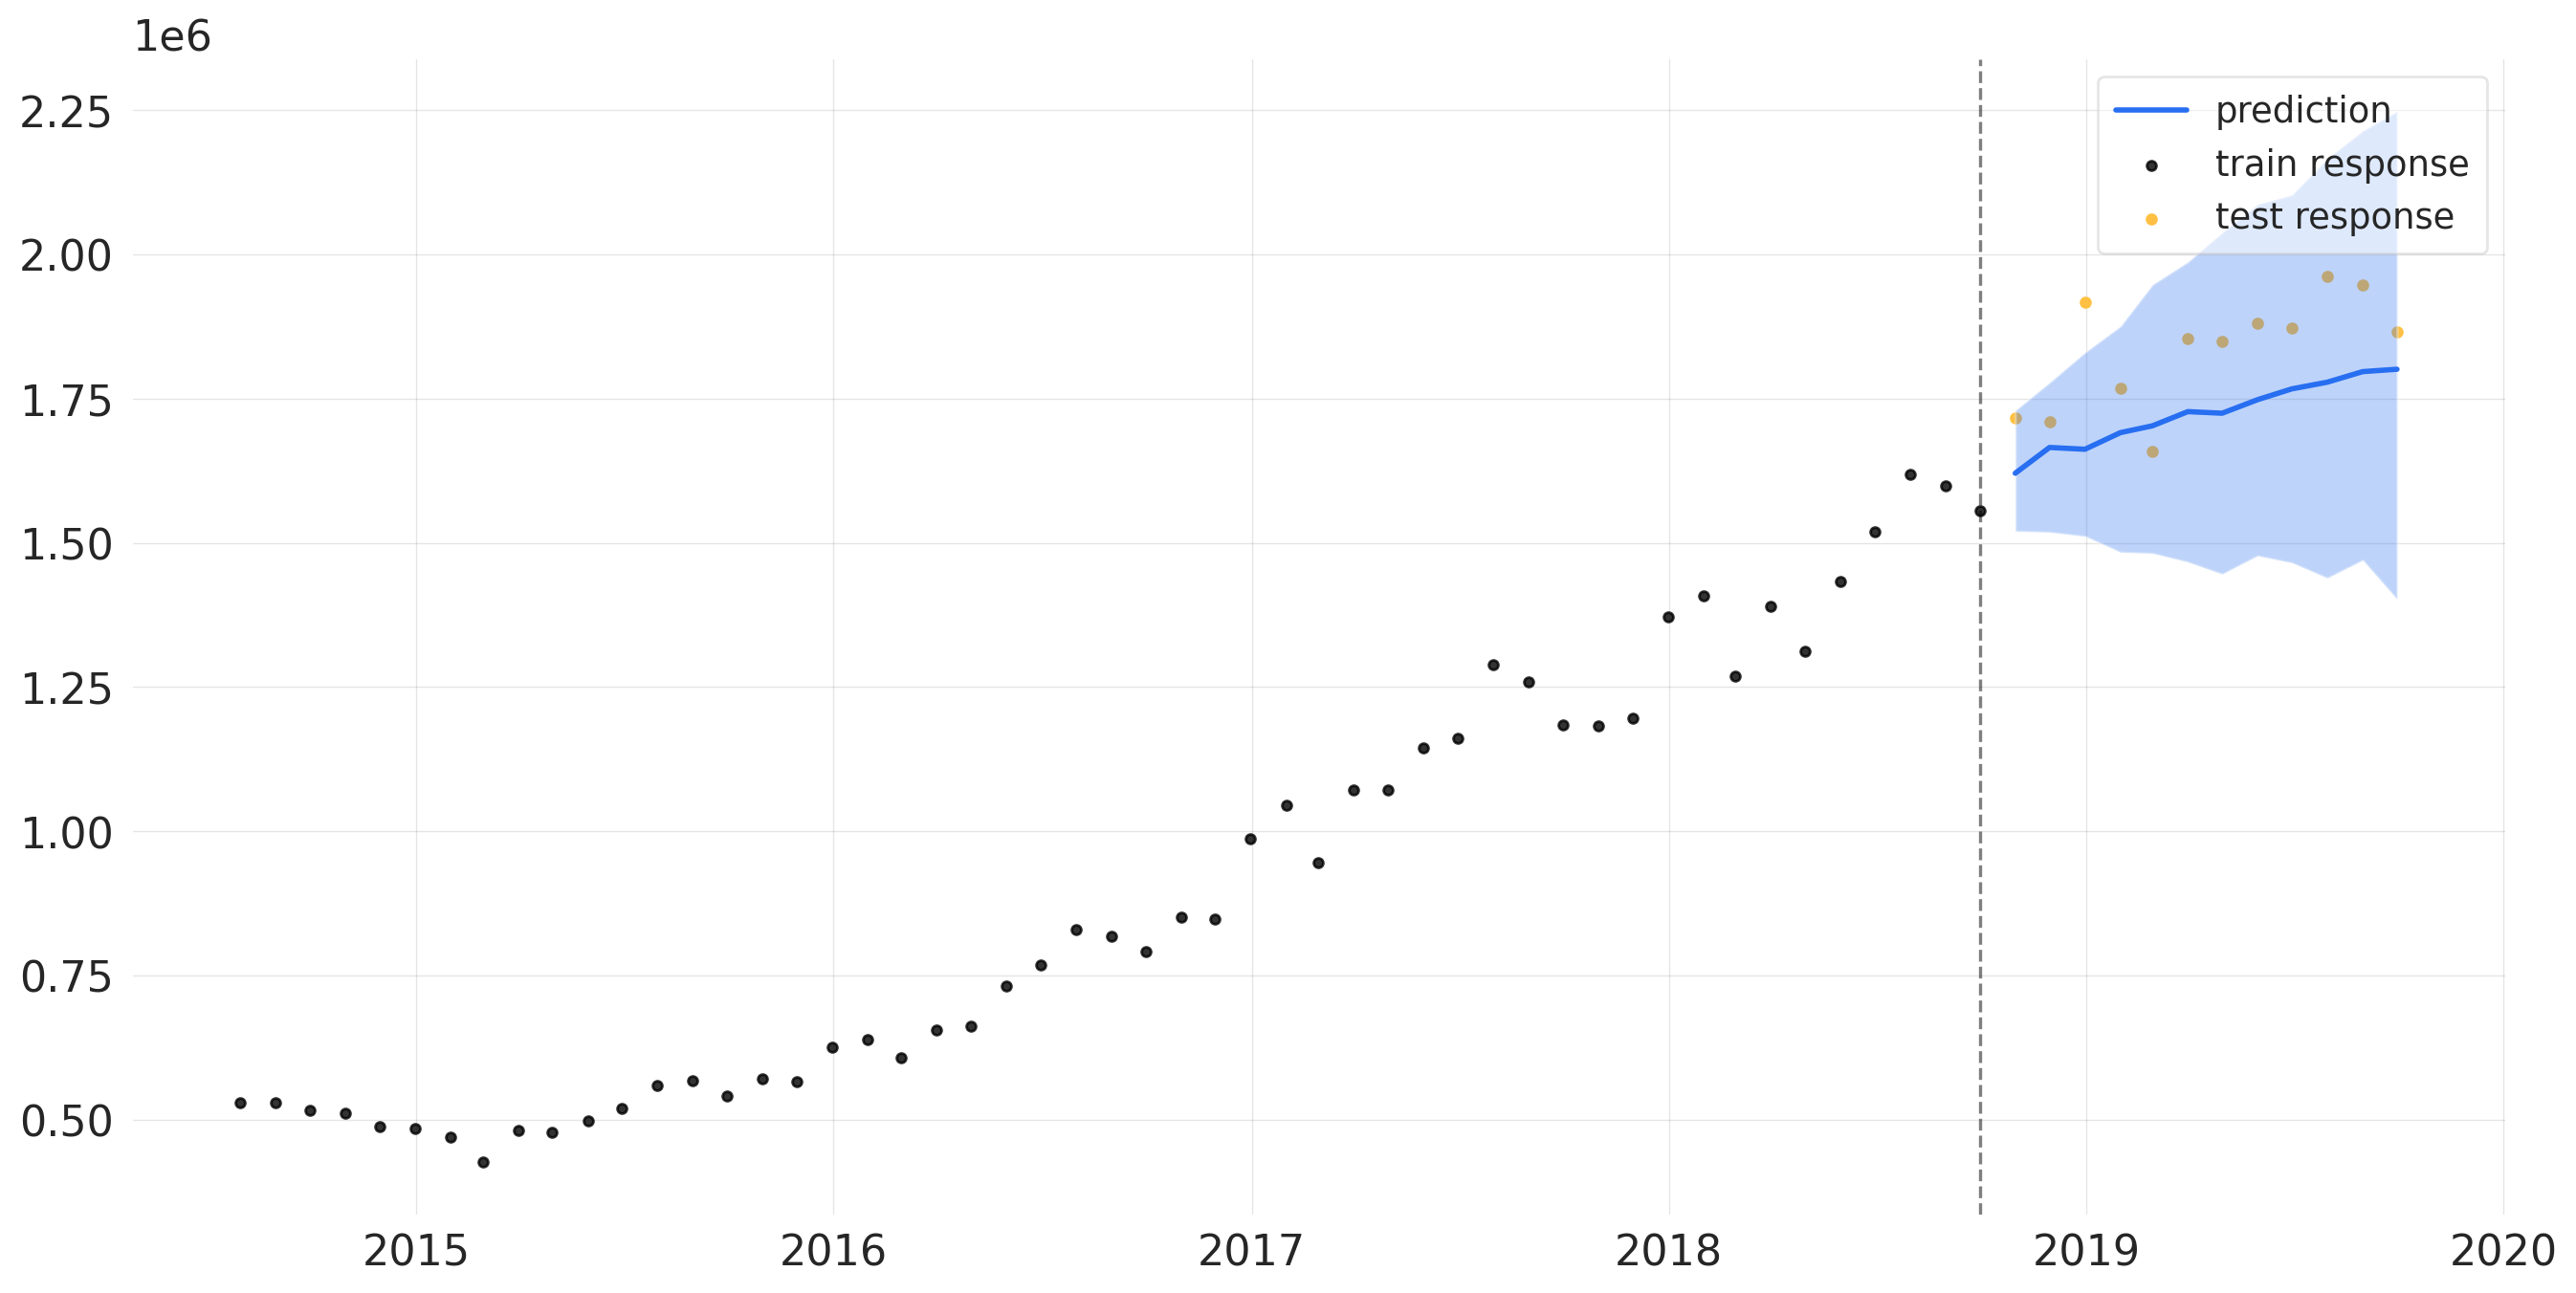

In [ ]:
pred_df = dlt.predict(test)

plot_predicted_data(train, pred_df, 'REPORTDATE', 'VALUE', 'prediction', test_actual_df=test);

In [ ]:
y_pred = dlt.predict(test)['prediction']
real_mse = RMSE(target_test, y_pred)
real_break = breakline(target_train.append(target_test), dlt.predict(train.append(test))['prediction'])

print("Orbit DLT RMSE:", real_mse)
print("Пробитие:", real_break)

Orbit DLT RMSE: 151757.00999700636
Пробитие: 1143481.3015662828


In [ ]:
result['Orbit DLT'] = [real_mse, real_break]

#### Prophet

In [ ]:
pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from prophet import Prophet

In [ ]:
train_prop = train.rename({'REPORTDATE': 'ds', 'VALUE': 'y'}, axis=1)
test_prop = test.rename({'REPORTDATE': 'ds', 'VALUE': 'y'}, axis=1)

In [ ]:
m = Prophet(daily_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative')
m.fit(train_prop)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpae6cmbw6/l9t6vwpd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpae6cmbw6/ub0qcn8q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94983', 'data', 'file=/tmp/tmpae6cmbw6/l9t6vwpd.json', 'init=/tmp/tmpae6cmbw6/ub0qcn8q.json', 'output', 'file=/tmp/tmpmf1ah5ab/prophet_model-20220825130900.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:09:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:09:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast = m.predict(test_prop)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2018-10-31,98289.718302,1.939386e+06,2.005067e+06,96912.421170,100194.540307,18.10982,18.10982,18.10982,19.011742,...,0.912828,0.912828,0.912828,-0.010906,-0.010906,-0.010906,0.0,0.0,0.0,1.966949e+06
1,2018-11-30,101730.077662,1.939212e+06,2.203774e+06,95871.242866,108950.720407,18.10982,18.10982,18.10982,19.227257,...,-0.574630,-0.574630,-0.574630,1.692066,1.692066,1.692066,0.0,0.0,0.0,2.057720e+06
2,2018-12-31,105285.115668,2.017808e+06,2.617686e+06,92650.538225,120194.794721,18.10982,18.10982,18.10982,20.778699,...,-1.356869,-1.356869,-1.356869,4.025748,4.025748,4.025748,0.0,0.0,0.0,2.292973e+06
3,2019-01-31,108840.153673,1.729476e+06,2.699399e+06,85926.281689,134115.351236,18.10982,18.10982,18.10982,19.127445,...,-0.339064,-0.339064,-0.339064,1.356689,1.356689,1.356689,0.0,0.0,0.0,2.190674e+06
4,2019-02-28,112051.155743,1.325632e+06,2.399724e+06,81200.326621,146992.767587,18.10982,18.10982,18.10982,15.325457,...,-0.339064,-0.339064,-0.339064,-2.445299,-2.445299,-2.445299,0.0,0.0,0.0,1.829286e+06


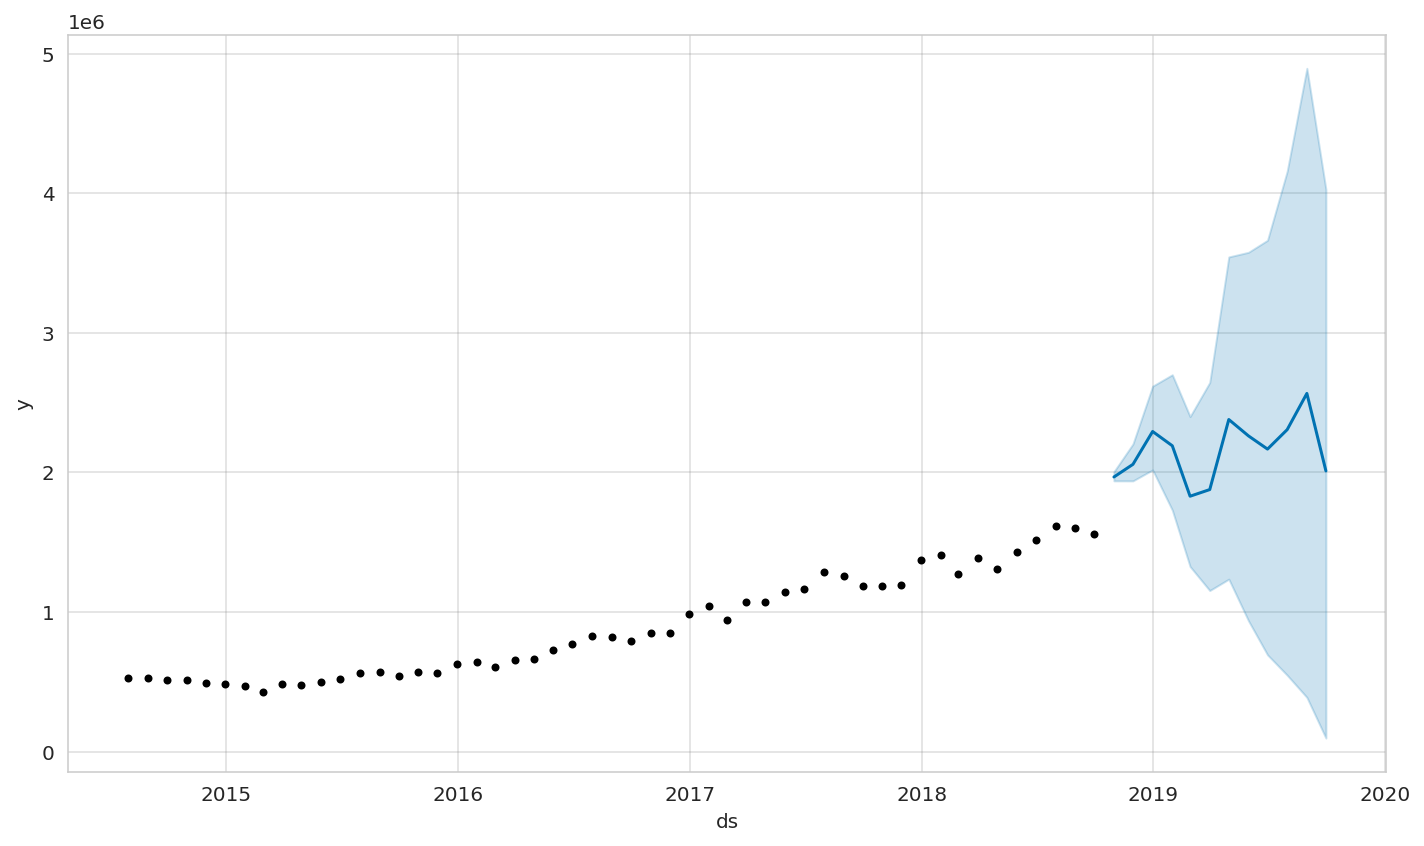

In [ ]:
fig1 = m.plot(forecast)

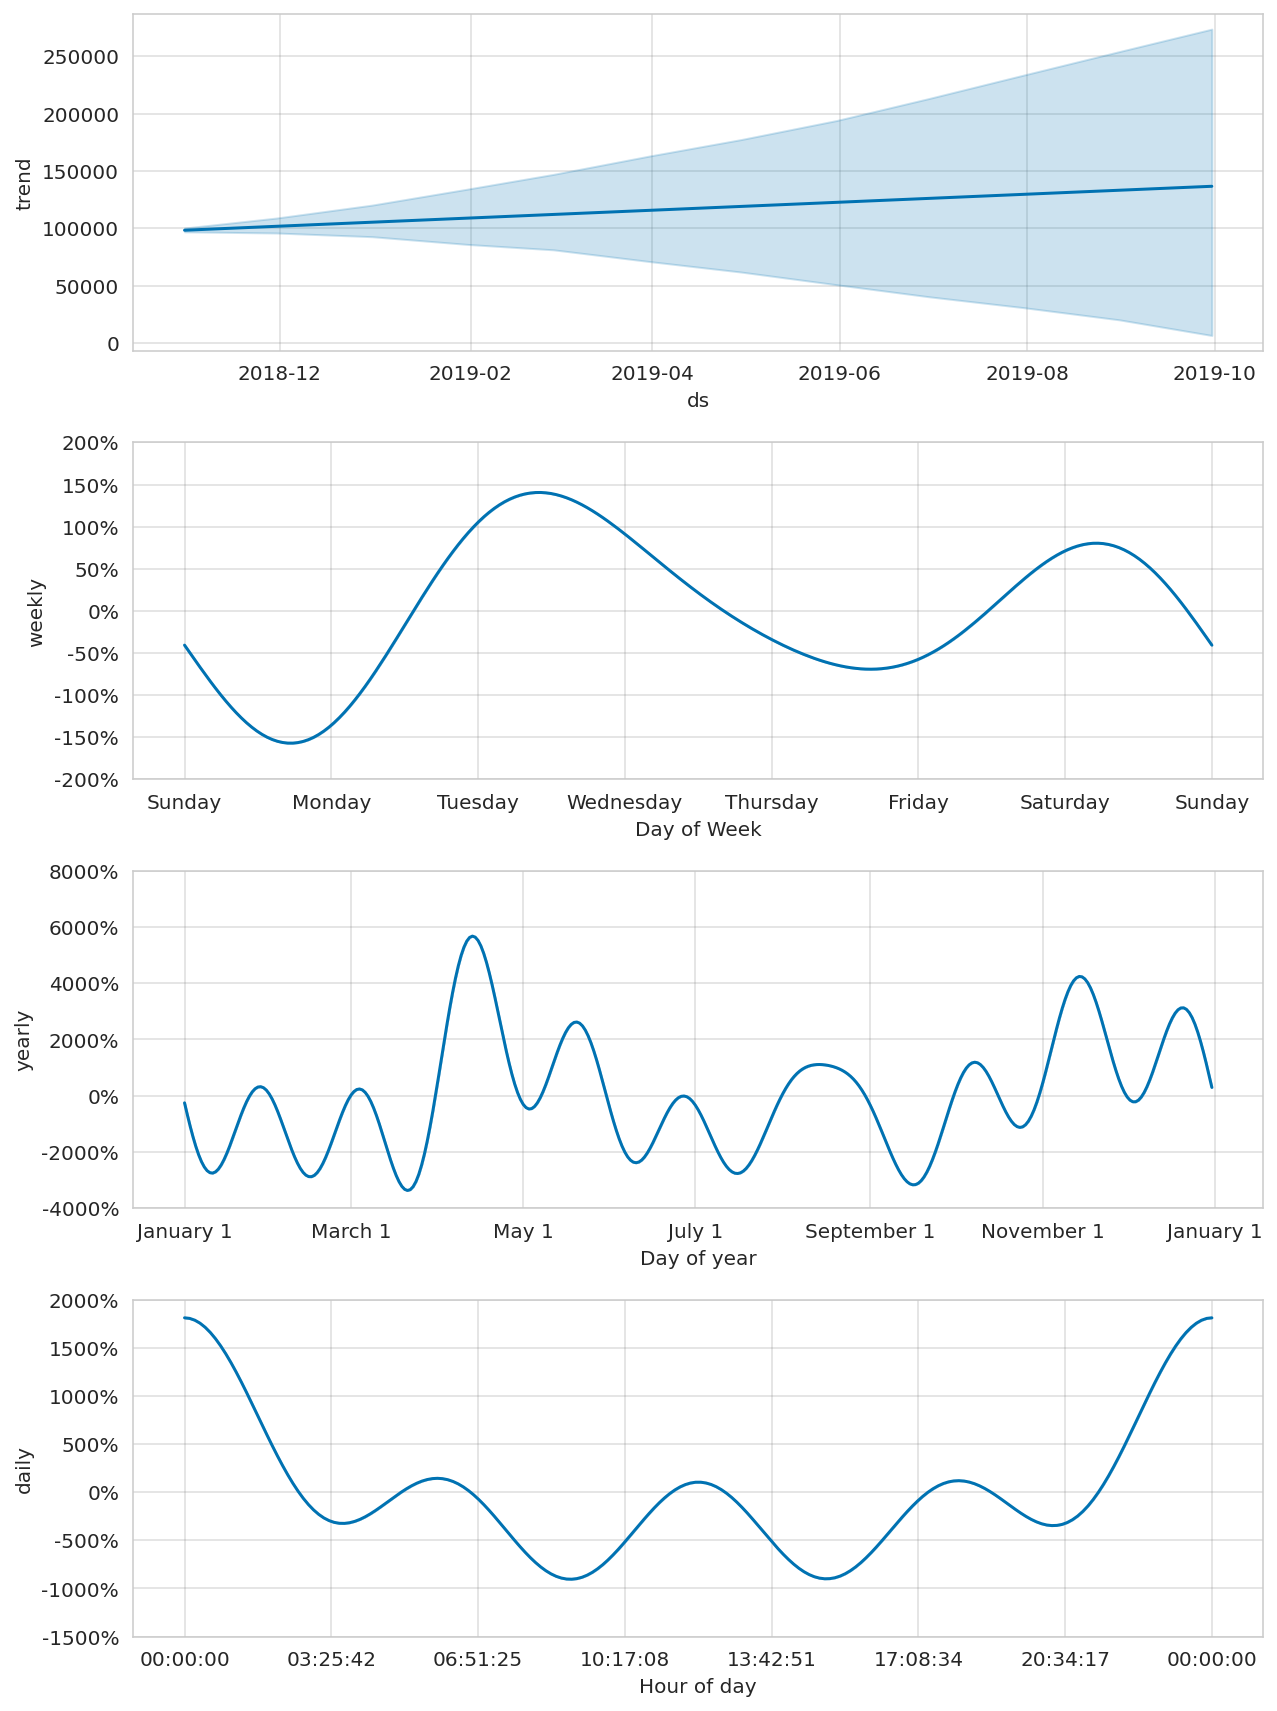

In [ ]:
fig2 = m.plot_components(forecast)


In [ ]:
y_pred = forecast['yhat']
real_mse = RMSE(target_test, y_pred)
real_break = breakline(target_train.append(target_test), m.predict(train_prop.append(test_prop))['yhat'])

print("Prophet RMSE:", real_mse)
print("Пробитие:", real_break)

Prophet RMSE: 361216.33120186196
Пробитие: 3900885.829170238


In [ ]:
result['Facebook prophet'] = [real_mse, real_break]

#### ARIMA

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 37.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

In [ ]:
one_month = one_month['VALUE']

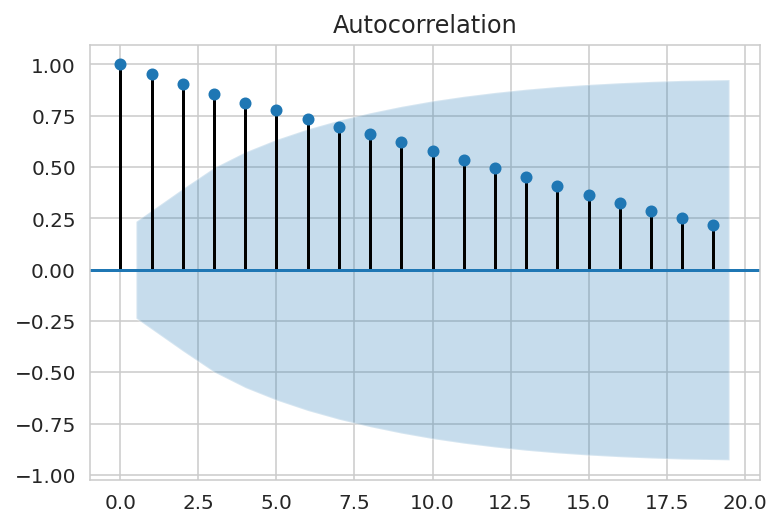

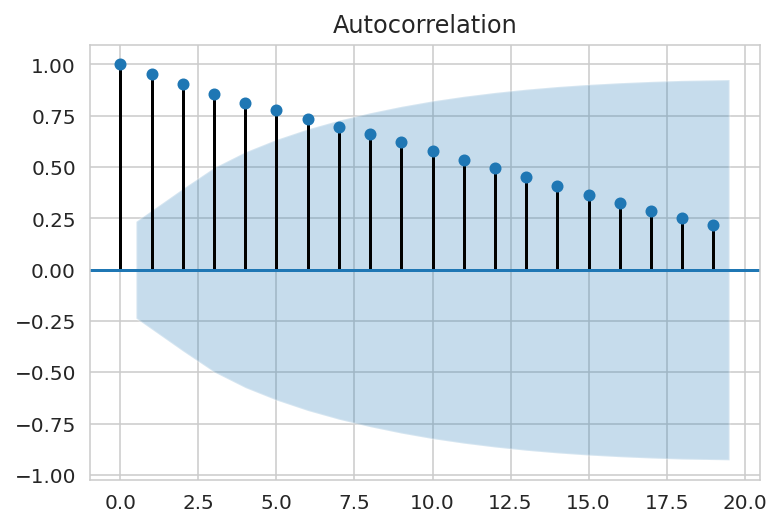

In [ ]:
plot_acf(one_month)

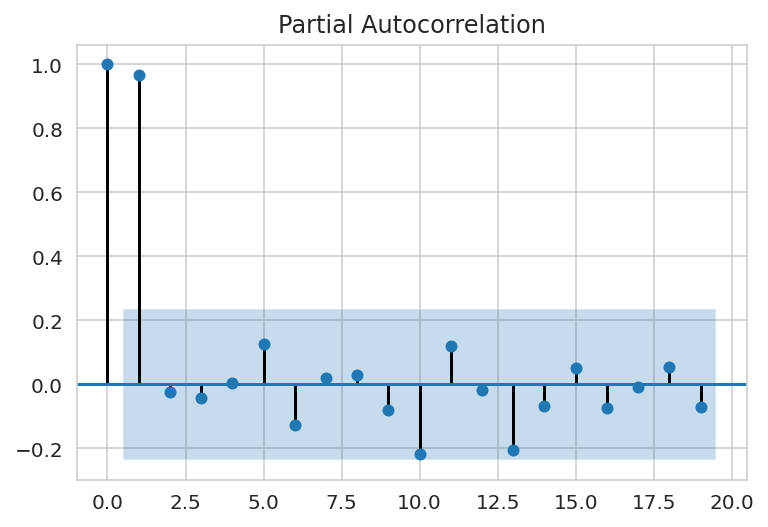

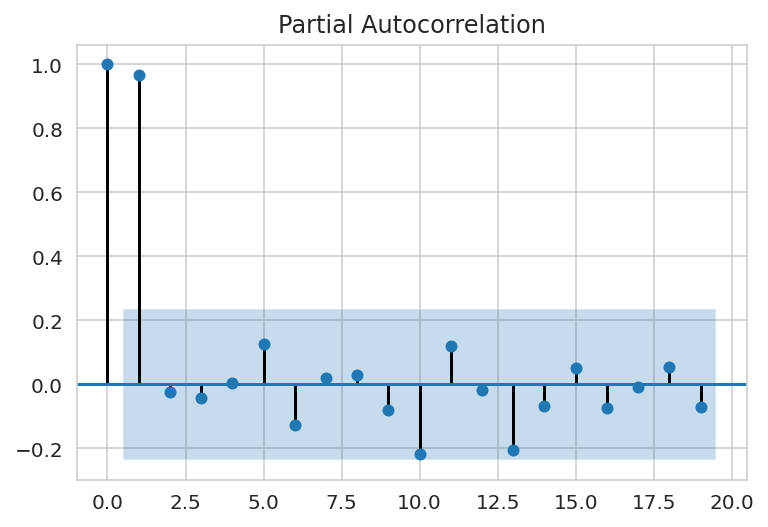

In [ ]:
plot_pacf(one_month)

In [ ]:
arima = pm.auto_arima(train['VALUE'],
                      test='adf',
                      seasonal=True,   
                      trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1250.108, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1250.303, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1250.536, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1253.244, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1252.404, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.762 seconds


In [ ]:
y_pred = arima.predict(n_periods = 12).values

In [ ]:
real_mse = RMSE(target_test, y_pred)
real_break = breakline(target_test, y_pred)

print("ARIMA RMSE:", real_mse)
print("Пробитие:", arima.predict(n_periods = target_test.append(target_train).shape[0]).values)

ARIMA RMSE: 159740.40304107638
Пробитие: [1576793.17101444 1597312.86280388 1617832.55459332 1638352.24638276
 1658871.9381722  1679391.62996164 1699911.32175108 1720431.01354052
 1740950.70532996 1761470.3971194  1781990.08890884 1802509.78069828
 1823029.47248772 1843549.16427716 1864068.8560666  1884588.54785604
 1905108.23964548 1925627.93143492 1946147.62322436 1966667.3150138
 1987187.00680324 2007706.69859268 2028226.39038212 2048746.08217156
 2069265.773961   2089785.46575044 2110305.15753988 2130824.84932932
 2151344.54111876 2171864.2329082  2192383.92469764 2212903.61648708
 2233423.30827652 2253943.00006596 2274462.6918554  2294982.38364484
 2315502.07543428 2336021.76722372 2356541.45901316 2377061.1508026
 2397580.84259204 2418100.53438148 2438620.22617092 2459139.91796036
 2479659.6097498  2500179.30153924 2520698.99332868 2541218.68511812
 2561738.37690756 2582258.068697   2602777.76048644 2623297.45227588
 2643817.14406532 2664336.83585476 2684856.5276442  2705376.2194

In [ ]:
result['ARIMA'] = [real_mse, real_break]

#### Auto-sklearn 

In [ ]:
!pip install auto-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 4.5 MB/s 
     |████████████████████████████████| 22.3 MB 1.8 MB/s 
     |████████████████████████████████| 4.3 MB 13.3 MB/s 
     |████████████████████████████████| 4.4 MB 42.1 MB/s 
     |████████████████████████████████| 260 kB 44.4 MB/s 
     |████████████████████████████████| 46 kB 673 kB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.14.7-py3-none-any.whl size=6602873 sha256=4187ddf35050b81292f4d2d618a2c29ff273461dcdbb4fffeca00c8b67e6aefe
  Stored in directory: /root/.cache/pip/wheels/ba/43/5c/2fbe6fd19e3af314cbc4aa808378068d8ddd6792064f4a2448
  Created wheel for pynisher: filename=pynisher-0.6.4-py3-none-any.whl size=7043 sha256=7f29a740e3d0470042dcd4d9d9fbff9d551c162ad6004252ba6b903d9cfd06f2
  Stored in directory: /root/.cache/pip/wheels/42/71/95/7555ec3253e1ba8add72ae5febf1b015d297f3b73ba296d6f6
  Created wheel for smac

In [ ]:
from autosklearn.regression import AutoSklearnRegressor

<font color='red'>Потребуется перезапустить ячейку</font>

In [ ]:
!mkdir tmp

In [ ]:
automl = AutoSklearnRegressor(
    time_left_for_this_task=60*2,
    per_run_time_limit=30,
    tmp_folder='/tmp/regression_tmp',
)

In [ ]:
automl.fit(features_train, target_train, dataset_name='sber')

AutoSklearnRegressor(per_run_time_limit=30, time_left_for_this_task=120,
                     tmp_folder='/tmp/regression_tmp')

In [ ]:
automl.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
17,1,0.60,extra_trees,0.027221,2.619029
4,2,0.32,gaussian_process,0.029300,1.626878
36,3,0.08,gaussian_process,0.060414,0.969738


In [ ]:
y_pred = automl.predict(features_test)

In [ ]:
real_mse = RMSE(target_test, y_pred)
real_break = breakline(target_train.append(target_test), automl.predict(features_train.append(features_test)))

print("Auto-sklearn RMSE:", real_mse)
print("Пробитие:", real_break)

Auto-sklearn RMSE: 271685.69706630515
Пробитие: 480731.59492800036


In [ ]:
result['Auto-sklearn'] = [real_mse, real_break]

# Анализ итоговых результатов

In [ ]:
result_pd = pd.DataFrame(result).T.rename({0: "RMSE", 1: "BreakLine"}, axis=1)

Попробуем найти модель, которая выдает минимальный `RMSE` и минимальную сумму пробития предсказанного порога:

In [ ]:
result_pd

,RMSE,BreakLine
LogReg,94275.479443,1.487419e+06
QuantReg_real,125322.882567,1.873067e+06
QuantReg_lower,136458.962726,2.212807e+05
QuantReg_upper,214526.437108,5.150723e+06
Orbit DLT,151757.009997,1.143481e+06
Facebook prophet,361216.331202,3.900886e+06
ARIMA,159740.403041,6.902732e+02
Auto-sklearn,271685.697066,4.807316e+05


In [ ]:
result_pd.sort_values(by=['BreakLine', 'RMSE'])

,RMSE,BreakLine
ARIMA,159740.403041,6.902732e+02
QuantReg_lower,136458.962726,2.212807e+05
Auto-sklearn,271685.697066,4.807316e+05
Orbit DLT,151757.009997,1.143481e+06
LogReg,94275.479443,1.487419e+06
QuantReg_real,125322.882567,1.873067e+06
Facebook prophet,361216.331202,3.900886e+06
QuantReg_upper,214526.437108,5.150723e+06


In [ ]:
y_pred_test = automl.predict(features_test)

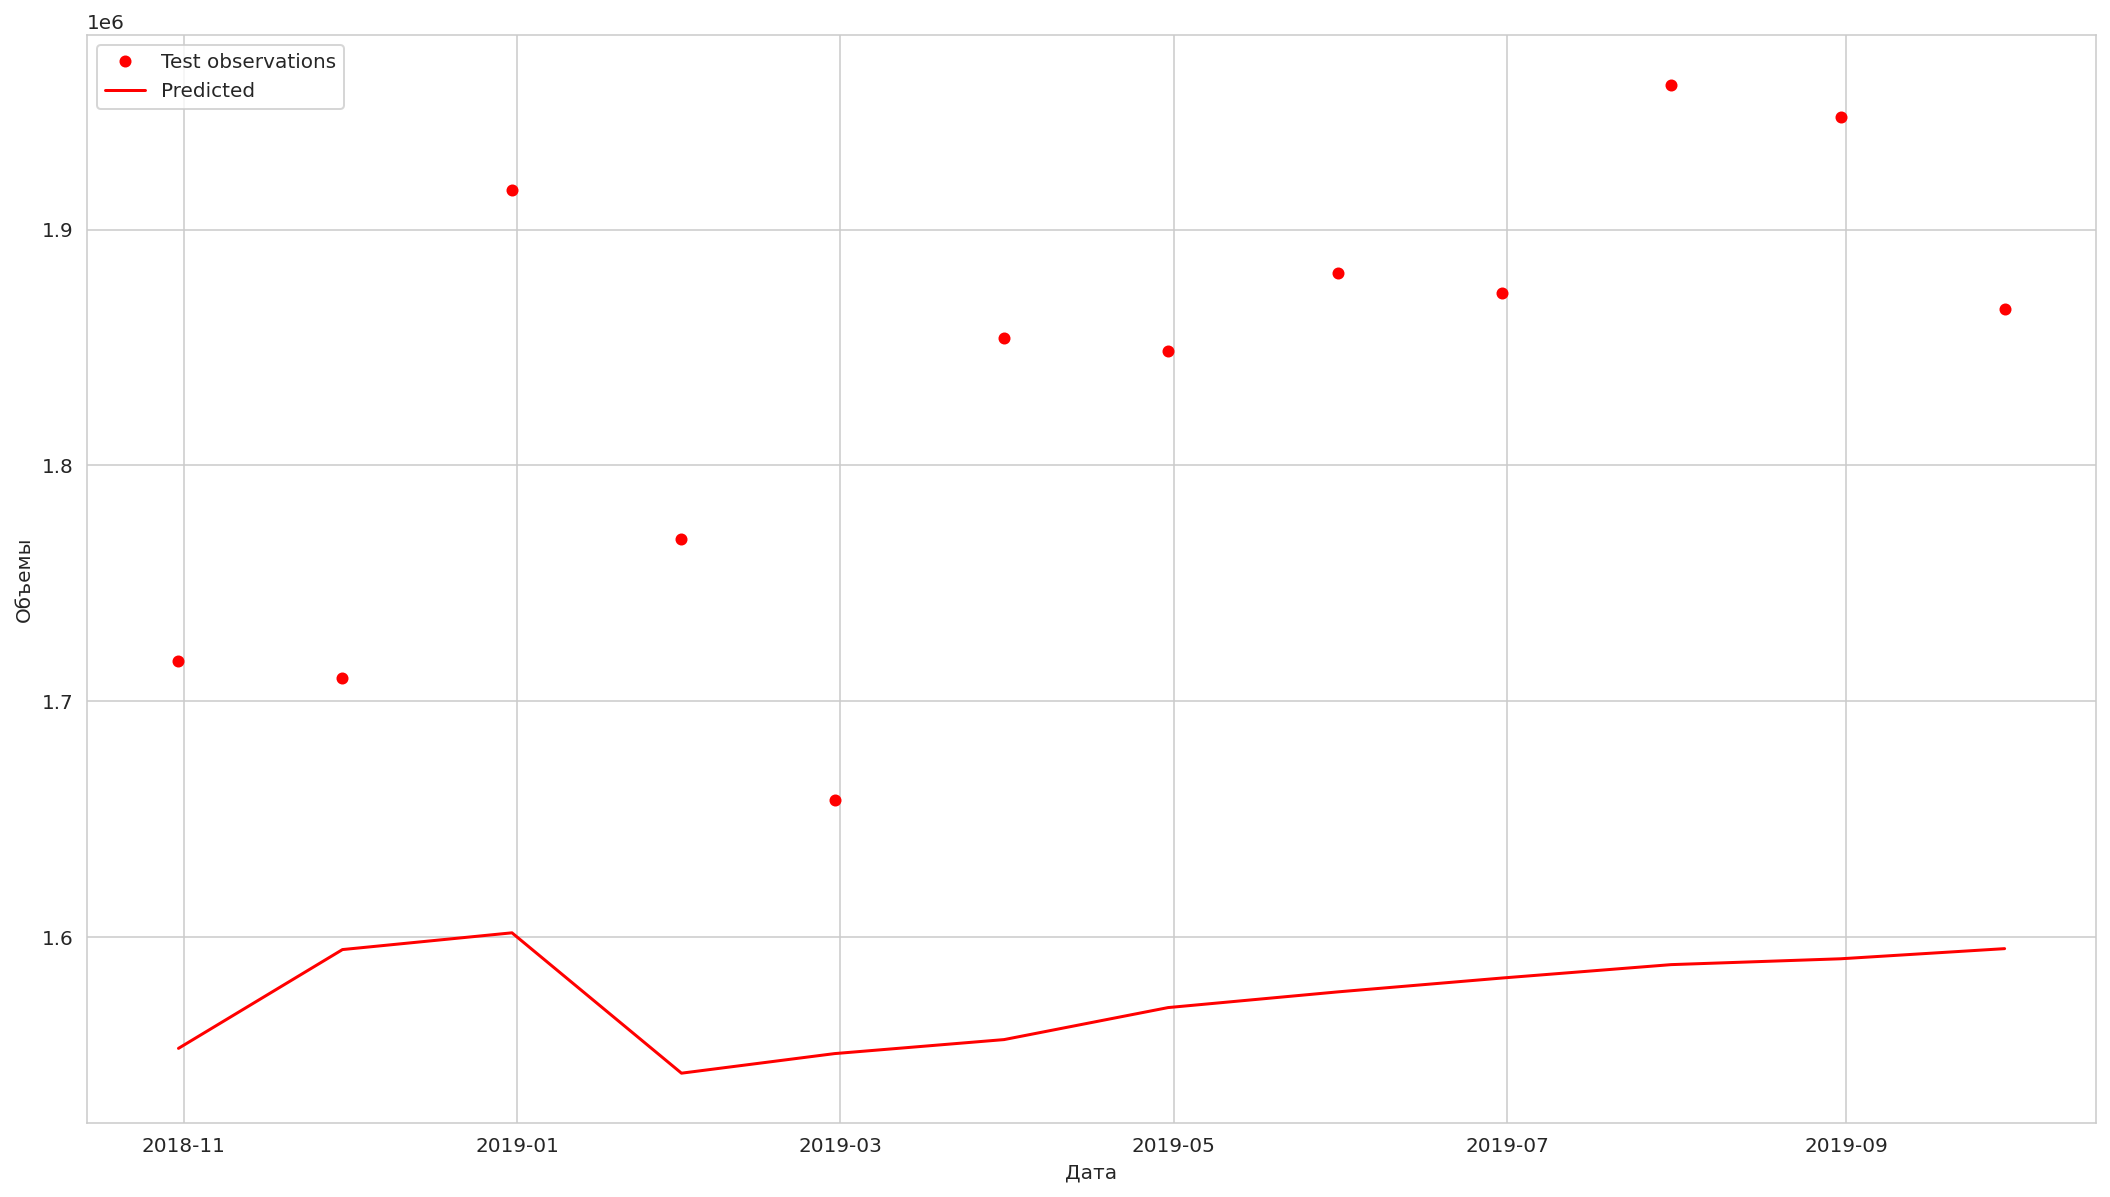

In [ ]:
fig = plt.figure(figsize=(18, 10))
plt.plot(features_test.index, target_test.values, "r.", markersize=10, label="Test observations")

plt.plot(features_test.index, y_pred_test, "r-", label="Predicted")
plt.xlabel("Дата")
plt.ylabel("Объемы")
plt.legend(loc="upper left")
plt.show()

In [ ]:
y_pred= automl.predict(features_train.tail(12).append(features_test))

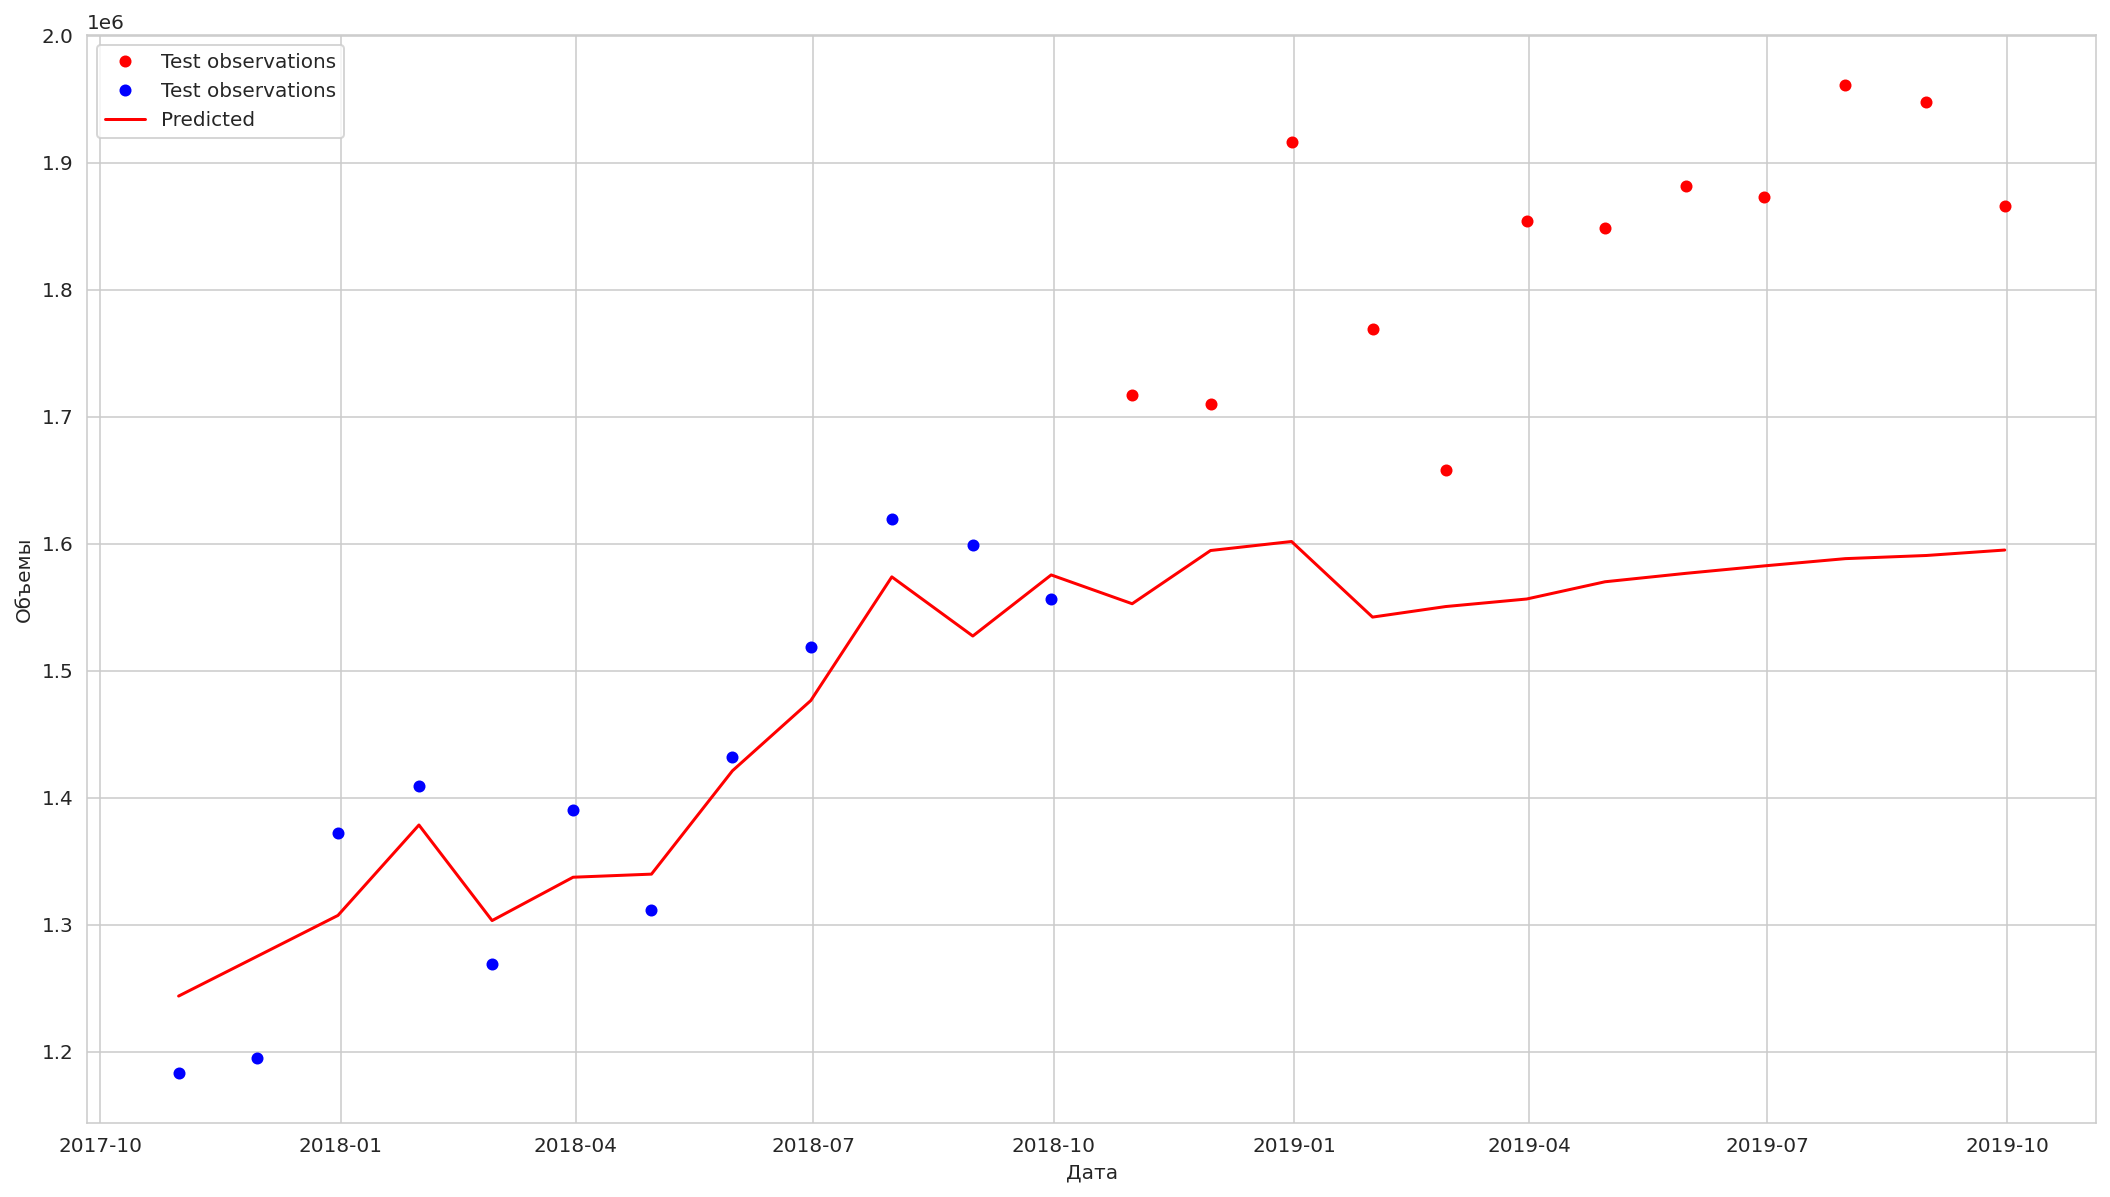

In [ ]:
fig = plt.figure(figsize=(18, 10))
plt.plot(features_test.index, target_test.values, "r.", markersize=10, label="Test observations")
plt.plot(features_train.tail(12).index, target_train[-12:].values, "b.", markersize=10, label="Test observations")

plt.plot(features_train.tail(12).append(features_test).index, y_pred, "r-", label="Predicted")
plt.xlabel("Дата")
plt.ylabel("Объемы")
plt.legend(loc="upper left")
plt.show()

Посмотрим прогноз на мин. остаток на все горизонты в будущем (тест. выборка)

 1М, 2М, 3М, 4М, 5М, 6М, 7М, 8М, 9М, 10М, 11М, 12М

In [ ]:
horizon = []
for i in range(1, 13):
  horizon.append(min(y_pred_test[:i]))

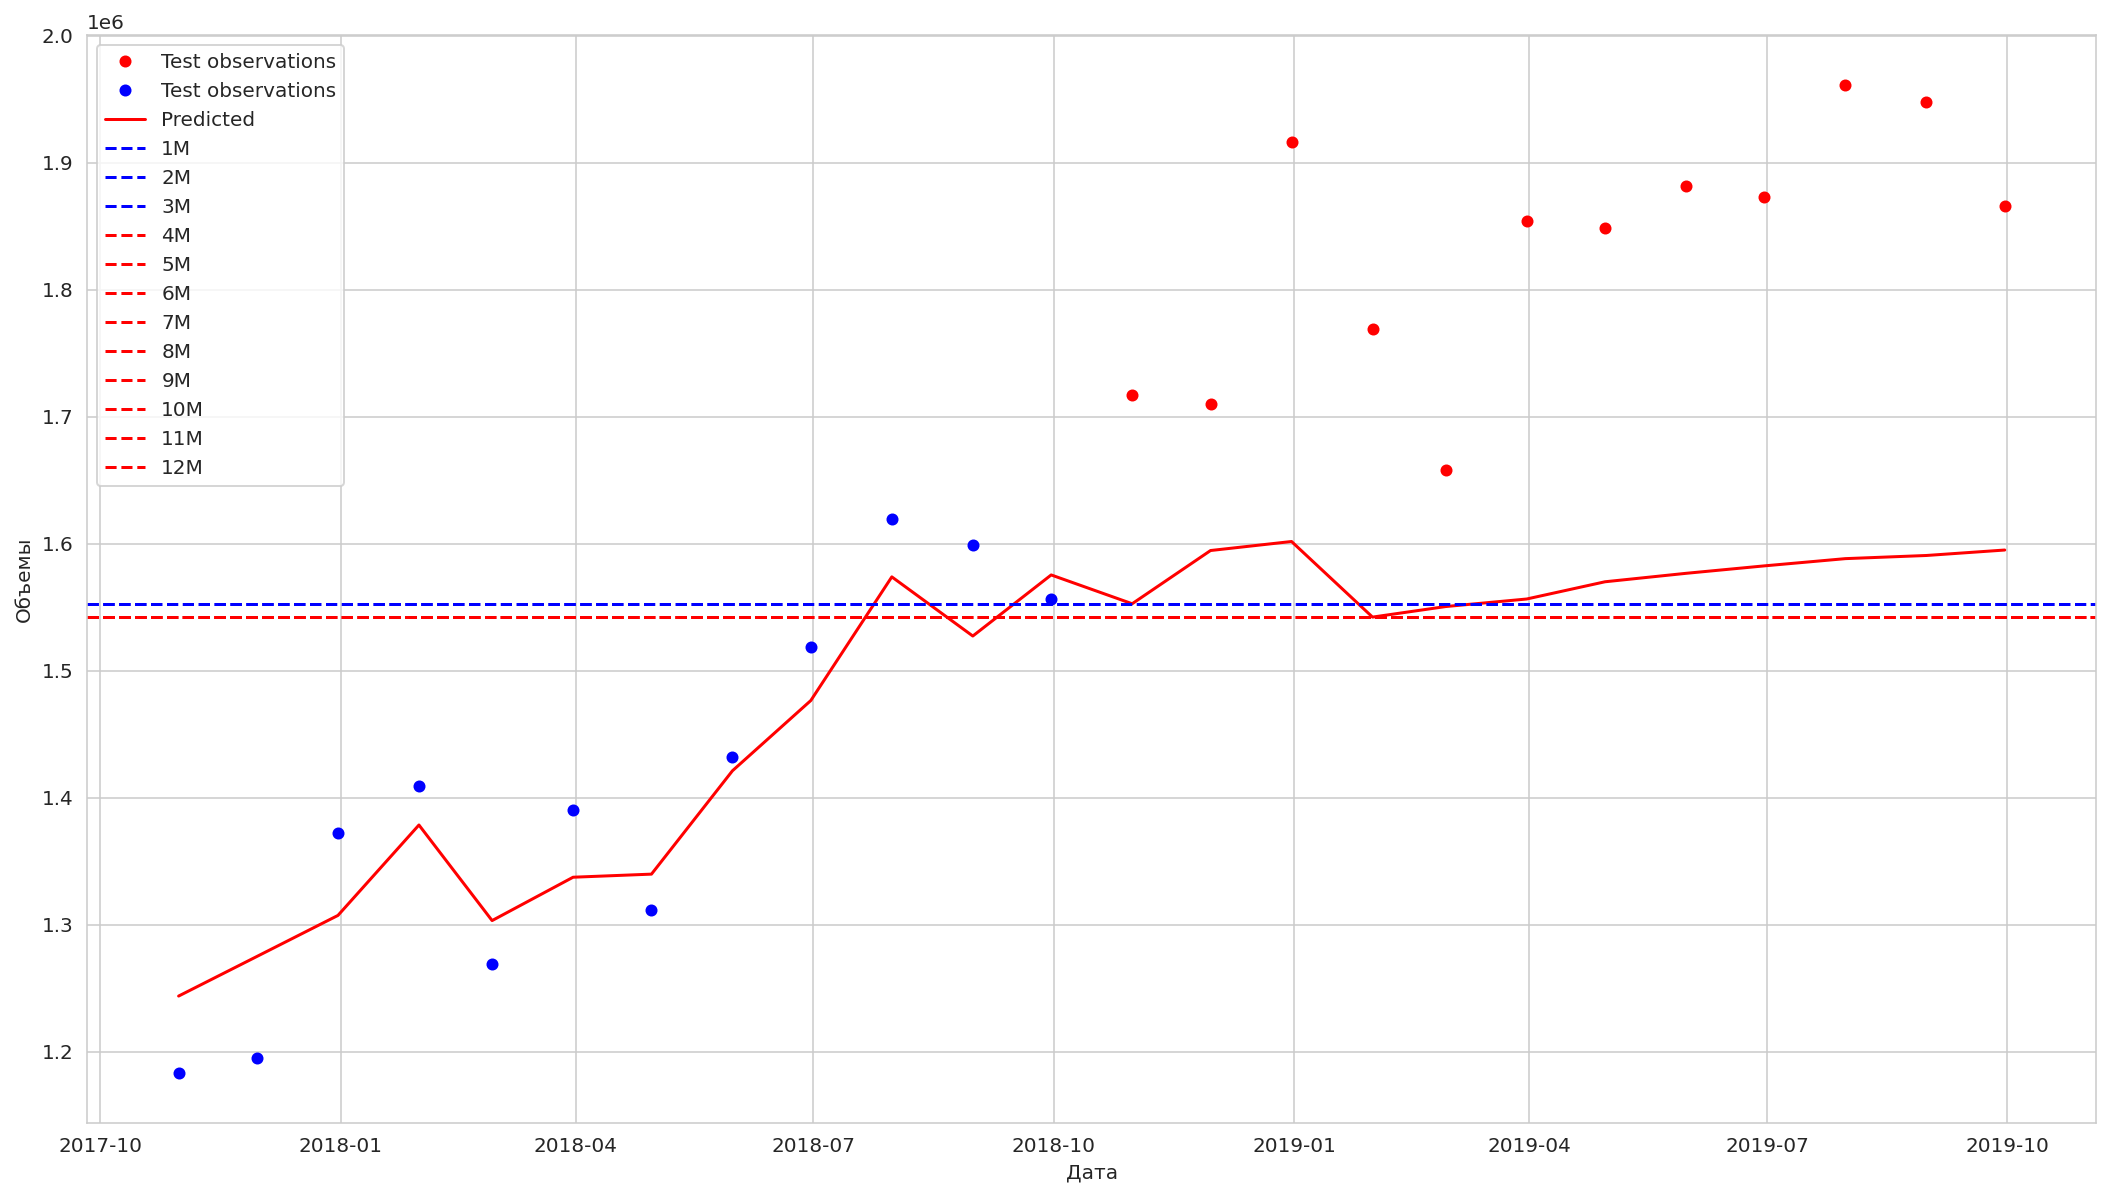

In [ ]:
fig = plt.figure(figsize=(18, 10))
plt.plot(features_test.index, target_test.values, "r.", markersize=10, label="Test observations")
plt.plot(features_train.tail(12).index, target_train[-12:].values, "b.", markersize=10, label="Test observations")

plt.plot(features_train.tail(12).append(features_test).index, y_pred, "r-", label="Predicted")
for i in range(3):
    plt.axhline(y=horizon[i], color='b', linestyle='--', label=str(i+1) + 'M')
for i in range(3, len(horizon)):
    plt.axhline(y=horizon[i], color='r', linestyle='--', label=str(i+1) + 'M')
plt.xlabel("Дата")
plt.ylabel("Объемы")
plt.legend(loc="upper left")
plt.show()

**Итоговый результат:**
* Был изучен и предобработан датасет `BC DC Сбер data.csv`
* Обучены модели:
  * Лог. регрессия
  * Квант. регрессия
  * Orbit
  * Prophet
  * ARIMA
  * Auto-sklearn
* Лучшим решением была выбрана модель **ARIMA**
* Итоговые предсказания на 1-12 месяцев были отражены на графике